In [1]:
from posebusters.posebusters import PoseBusters
from rdkit import Chem
import os
import pandas as pd
import re 
from typing import List

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Loading and processing results

In [3]:
from Approach import DockingApproach, DiffDockApproach, ICMApproach, ChaiApproach, VinaApproach, GninaApproach, SurfDockApproach
def run_posebusters(
    approach: DockingApproach,
    base_outdir: str,
    data_dir: str,
    top_n: int = 5,
    docking: bool = False,
) -> pd.DataFrame:
    """
    For each protein subdir in base_outdir:
      - list up to top_n SDF files (method-specific naming)
      - run PoseBusters on each
      - parse a numeric score or confidence if available
      - collect results in a DataFrame
    """
    pb = PoseBusters(config="redock", top_n=None)
    method_name = approach.get_name()
    all_rows = []

    for protein_name in os.listdir(base_outdir):
        protein_dir = os.path.join(base_outdir, protein_name)
        if not os.path.isdir(protein_dir):
            continue

        # Retrieve up to top-N .sdf file paths
        sdf_paths = approach.list_top_n_files(protein_dir, top_n)
        if not sdf_paths:
            print(f"[{method_name}] No top-{top_n} SDF files found for {protein_name}")
            continue

        # References
        true_ligand = os.path.join(data_dir, protein_name, f"{protein_name}_ligand.sdf")
        protein_pdb = os.path.join(data_dir, protein_name, f"{protein_name}_protein.pdb")
        if not (os.path.isfile(true_ligand) and os.path.isfile(protein_pdb)):
            print(f"[{method_name}] Missing reference for {protein_name}")
            continue

        rank_counter = 1
        for sdf_path in sdf_paths:
            try:
                df_pb = pb.bust(
                    mol_pred=sdf_path,
                    mol_true=true_ligand,
                    mol_cond=protein_pdb,
                    full_report=True
                )
                # parse numeric score or confidence if available
                numeric_score = approach.parse_score(sdf_path)

                df_pb["score"] = numeric_score  # or "confidence_score" or "docking_score"
                df_pb["method"] = method_name
                df_pb["protein"] = protein_name
                df_pb["rank"] = rank_counter
                rank_counter += 1

                all_rows.append(df_pb)
            except Exception as e:
                print(f"[{method_name}] [ERROR] PoseBusters failed for {protein_name}: {e}")

    if not all_rows:
        return pd.DataFrame()
    return pd.concat(all_rows, ignore_index=True)

In [4]:
# The folder containing subdirectories like 5S8I_2LY, 5SD5_HWI, etc.
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks"

exp_name = "posebusters_benchmark_outputs_1"

# Initialize your approaches
approaches = [
    ICMApproach(),
    DiffDockApproach(),
    ChaiApproach(),
    VinaApproach()
    # ... add more if needed
]

BASE_DIRS = {
    "icm": f"{base_outdir}/ICM/inference/icm_manual_{exp_name}",
    "diffdock": f"{base_outdir}/Diffdock/inference/diffdock_posebusters_benchmark_output_orig_structure_1",
    "diffdock_pocket_only": f"{base_outdir}/Diffdock/inference/diffdock_pocket_only_posebusters_benchmark_output_orig_structure_0",
    "chai-1": f"{base_outdir}/chai-lab/inference/chai-lab_{exp_name}",
    "vina": f"{base_outdir}/Vina/inference/GT_pocket_vina_posebusters_benchmark_outputs_orig_structure_2",    
    "gnina":f"{base_outdir}/GNINA/inference/GT_pocket_gnina_posebusters_benchmark_outputs_1"
    # ...
}

# The folder containing the real (crystal) ligand and protein PDB:
#  PoseBench/data/posebusters_benchmark_set/<protein>/
DATA_DIR = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set"


In [ ]:
df_all = []

for approach in approaches:
    method_name = approach.get_name()
    base_outdir = BASE_DIRS[method_name]
    df_method = run_posebusters(
        approach,
        base_outdir=base_outdir,
        data_dir=DATA_DIR,
        top_n=5
    )
    df_all.append(df_method)

df_combined = pd.concat(df_all, ignore_index=True)
print(df_combined.shape)
df_combined.head()

# Now you have a single DataFrame with columns:
#   - 'protein'
#   - 'method' (icm / diffdock / chai-1)
#   - 'rank' (1..5)
#   - 'score' (NaN or a float)
#   - 'rmsd', 'rmsd_≤_2å', etc. from PoseBusters
# You can groupby or pivot as you wish.

In [6]:
df_combined.to_csv(f"{exp_name}_posebusters_results.csv", index=False)

### custom approaches to add

In [ ]:
# Run PoseBusters for a custom approach
base_outdir = BASE_DIRS["gnina"]
df_method = run_posebusters(GninaApproach(), base_outdir, DATA_DIR, top_n=5, docking=False)
df_method.to_csv("gnina_posebusters_results.csv", index=False)

In [ ]:
method_name = 'vina'
base_outdir = BASE_DIRS[method_name]
df_method = run_posebusters(
    VinaApproach(),
    base_outdir=base_outdir,
    data_dir=DATA_DIR,
    top_n=5
)
df_method.to_csv("vina_posebusters_results.csv", index=False)

In [ ]:
method_name = 'diffdock_pocket_only'
base_outdir = BASE_DIRS[method_name]
df_method = run_posebusters(
    DiffDockApproach(),
    base_outdir=base_outdir,
    data_dir=DATA_DIR,
    top_n=5
)
df_method.to_csv(f"{method_name}_posebusters_results.csv", index=False)

In [4]:
method_name = "surfdock"
base_outdir = "/Users/aoxu/Downloads/SurfDock_docking_result"
df_method = run_posebusters(
    SurfDockApproach(),
    base_outdir=base_outdir,
    data_dir=DATA_DIR,
    top_n=5
)
df_method.to_csv(f"{method_name}_posebusters_results.csv", index=False)

Parsed from 7ZDY_7ZDY_6MJ_Y_903_7ZDY_6MJ_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_1_rmsd_0.7684781583003149_confidence_154.47067041126454.sdf: RMSD=0.7684781583003149, confidence=154.47067041126454
Parsed from 7ZDY_7ZDY_6MJ_Y_903_7ZDY_6MJ_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_2_rmsd_0.6814203653875555_confidence_147.6561433705661.sdf: RMSD=0.6814203653875555, confidence=147.6561433705661
Parsed from 7ZDY_7ZDY_6MJ_Y_903_7ZDY_6MJ_ligand.sdf_file_inner_idx_0_sample_idx_13_rank_3_rmsd_0.8036722136101041_confidence_144.56534340755636.sdf: RMSD=0.8036722136101041, confidence=144.56534340755636
Parsed from 7ZDY_7ZDY_6MJ_Y_903_7ZDY_6MJ_ligand.sdf_file_inner_idx_0_sample_idx_17_rank_4_rmsd_0.7144870381014796_confidence_139.9451857172863.sdf: RMSD=0.7144870381014796, confidence=139.9451857172863
Parsed from 7ZDY_7ZDY_6MJ_Y_903_7ZDY_6MJ_ligand.sdf_file_inner_idx_0_sample_idx_15_rank_5_rmsd_0.9395071483731985_confidence_137.22740665481712.sdf: RMSD=0.9395071483731985, confidence=137

[11:39:54] Cannot assign bond directions!
[11:39:54] Cannot assign bond directions!


Parsed from 7UJF_7UJF_R3V_C_601_7UJF_R3V_ligand.sdf_file_inner_idx_0_sample_idx_23_rank_5_rmsd_1.8072155705396395_confidence_161.07616709653456.sdf: RMSD=1.8072155705396395, confidence=161.07616709653456


[11:40:43] Cannot assign bond directions!
[11:40:43] Cannot assign bond directions!


Parsed from 8F4J_8F4J_PHO_D_402_8F4J_PHO_ligand.sdf_file_inner_idx_0_sample_idx_31_rank_1_rmsd_2.9556650666005204_confidence_122.18626139547277.sdf: RMSD=2.9556650666005204, confidence=122.18626139547277


[11:41:28] Cannot assign bond directions!
[11:41:28] Cannot assign bond directions!


Parsed from 8F4J_8F4J_PHO_D_402_8F4J_PHO_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_2_rmsd_5.328947691666041_confidence_82.81648926253087.sdf: RMSD=5.328947691666041, confidence=82.81648926253087


[11:42:08] Cannot assign bond directions!
[11:42:08] Cannot assign bond directions!


Parsed from 8F4J_8F4J_PHO_D_402_8F4J_PHO_ligand.sdf_file_inner_idx_0_sample_idx_9_rank_3_rmsd_5.199244084675115_confidence_79.99015023916246.sdf: RMSD=5.199244084675115, confidence=79.99015023916246


[11:42:47] Cannot assign bond directions!
[11:42:47] Cannot assign bond directions!


Parsed from 8F4J_8F4J_PHO_D_402_8F4J_PHO_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_4_rmsd_5.774251122807322_confidence_72.92899383165837.sdf: RMSD=5.774251122807322, confidence=72.92899383165837
Parsed from 8F4J_8F4J_PHO_D_402_8F4J_PHO_ligand.sdf_file_inner_idx_0_sample_idx_38_rank_5_rmsd_5.267578711767276_confidence_71.41088760654026.sdf: RMSD=5.267578711767276, confidence=71.41088760654026
Parsed from 7BLA_7BLA_WCS_A_1901_7BLA_WCS_ligand.sdf_file_inner_idx_0_sample_idx_36_rank_1_rmsd_5.823926029512903_confidence_132.5029530825502.sdf: RMSD=5.823926029512903, confidence=132.5029530825502
Parsed from 7BLA_7BLA_WCS_A_1901_7BLA_WCS_ligand.sdf_file_inner_idx_0_sample_idx_32_rank_2_rmsd_5.752465029045568_confidence_122.14853999463007.sdf: RMSD=5.752465029045568, confidence=122.14853999463007
Parsed from 7BLA_7BLA_WCS_A_1901_7BLA_WCS_ligand.sdf_file_inner_idx_0_sample_idx_20_rank_3_rmsd_5.967370402057885_confidence_108.29768740685985.sdf: RMSD=5.967370402057885, confidence=108.29768740

[11:52:06] Conflicting single bond directions around double bond at index 7.
[11:52:06]   BondStereo set to STEREONONE and single bond directions set to NONE.


Parsed from 7TM6_7TM6_GPJ_A_502_7TM6_GPJ_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_5_rmsd_0.4014078697737699_confidence_232.54427932086753.sdf: RMSD=0.4014078697737699, confidence=232.54427932086753


[11:52:07] Conflicting single bond directions around double bond at index 7.
[11:52:07]   BondStereo set to STEREONONE and single bond directions set to NONE.


Parsed from 7QPP_7QPP_VDX_A_501_7QPP_VDX_ligand.sdf_file_inner_idx_0_sample_idx_33_rank_1_rmsd_1.784988207455028_confidence_284.433358322049.sdf: RMSD=1.784988207455028, confidence=284.433358322049


[11:52:07] Conflicting single bond directions around double bond at index 7.
[11:52:07]   BondStereo set to STEREONONE and single bond directions set to NONE.


Parsed from 7QPP_7QPP_VDX_A_501_7QPP_VDX_ligand.sdf_file_inner_idx_0_sample_idx_0_rank_2_rmsd_1.5350094656757498_confidence_257.68372926155223.sdf: RMSD=1.5350094656757498, confidence=257.68372926155223
Parsed from 7QPP_7QPP_VDX_A_501_7QPP_VDX_ligand.sdf_file_inner_idx_0_sample_idx_14_rank_3_rmsd_1.9739950857040698_confidence_242.03961817361952.sdf: RMSD=1.9739950857040698, confidence=242.03961817361952


[11:52:09] Conflicting single bond directions around double bond at index 7.
[11:52:09]   BondStereo set to STEREONONE and single bond directions set to NONE.


Parsed from 7QPP_7QPP_VDX_A_501_7QPP_VDX_ligand.sdf_file_inner_idx_0_sample_idx_16_rank_4_rmsd_1.959838462660162_confidence_236.80889372880077.sdf: RMSD=1.959838462660162, confidence=236.80889372880077
Parsed from 7QPP_7QPP_VDX_A_501_7QPP_VDX_ligand.sdf_file_inner_idx_0_sample_idx_11_rank_5_rmsd_2.0263186137861107_confidence_232.6835350438277.sdf: RMSD=2.0263186137861107, confidence=232.6835350438277
Parsed from 6YQW_6YQW_82I_A_201_6YQW_82I_ligand.sdf_file_inner_idx_0_sample_idx_5_rank_1_rmsd_0.2987338406589399_confidence_210.9302977841842.sdf: RMSD=0.2987338406589399, confidence=210.9302977841842
Parsed from 6YQW_6YQW_82I_A_201_6YQW_82I_ligand.sdf_file_inner_idx_0_sample_idx_24_rank_2_rmsd_0.2608132154802301_confidence_208.98396768890822.sdf: RMSD=0.2608132154802301, confidence=208.98396768890822
Parsed from 6YQW_6YQW_82I_A_201_6YQW_82I_ligand.sdf_file_inner_idx_0_sample_idx_9_rank_3_rmsd_0.21990928189880982_confidence_205.80287219748047.sdf: RMSD=0.21990928189880982, confidence=205.8

# Overall Analysis

### Basic sumaries and Distributions 

In [6]:
# The folder containing subdirectories like 5S8I_2LY, 5SD5_HWI, etc.
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks"
exp_name = "posebusters_benchmark_outputs_1"
df_combined = pd.read_csv(f"{exp_name}_posebusters_results.csv")

In [7]:
df_method = pd.read_csv("vina_posebusters_results.csv")
df_combined = pd.concat([df_combined, df_method], ignore_index=True)

In [8]:
df_method = pd.read_csv("gnina_posebusters_results.csv")
df_combined = pd.concat([df_combined, df_method], ignore_index=True)

In [9]:
df_method = pd.read_csv("diffdock_pocket_only_posebusters_results.csv")
df_method["method"] = "diffdock_pocket_only"
df_combined = pd.concat([df_combined, df_method], ignore_index=True)

In [10]:
df_method = pd.read_csv("surfdock_posebusters_results.csv")
df_method["method"] = "surfdock"
df_combined = pd.concat([df_combined, df_method], ignore_index=True)

In [11]:
for col in df_combined.columns:
    print(col)

Unnamed: 0
mol_pred_loaded
mol_true_loaded
mol_cond_loaded
sanitization
inchi_convertible
all_atoms_connected
molecular_formula
molecular_bonds
double_bond_stereochemistry
tetrahedral_chirality
bond_lengths
bond_angles
internal_steric_clash
aromatic_ring_flatness
double_bond_flatness
internal_energy
protein-ligand_maximum_distance
minimum_distance_to_protein
minimum_distance_to_organic_cofactors
minimum_distance_to_inorganic_cofactors
minimum_distance_to_waters
volume_overlap_with_protein
volume_overlap_with_organic_cofactors
volume_overlap_with_inorganic_cofactors
volume_overlap_with_waters
rmsd_≤_2å
passes_valence_checks
passes_kekulization
inchi_crystal_valid
inchi_docked_valid
inchi_crystal
inchi_docked
inchi_overall
inchi_version
stereochemistry_preserved
hydrogens
net_charge
protons
stereo_sp3
stereo_sp3_inverted
stereo_type
number_bonds
shortest_bond_relative_length
longest_bond_relative_length
number_short_outlier_bonds
number_long_outlier_bonds
number_angles
most_extreme_relat

In [12]:
df_combined["method"].value_counts()

method
gnina                   2140
surfdock                2140
vina                    2075
icm                     1393
chai-1                  1391
diffdock_pocket_only    1290
diffdock                1045
Name: count, dtype: int64

In [13]:
df_combined[(df_combined['method'] == 'vina') ].shape

(2075, 133)

In [14]:
# Get proteins present in ICM method
icm_proteins = df_combined[df_combined['method'] == 'icm']['protein'].unique()
# Filter vina data to keep only proteins that exist in ICM
df_combined_filtered = df_combined[
      (df_combined['protein'].isin(icm_proteins))]


# # Filter gnina data to keep only proteins that exist in ICM
# df_combined_filtered = df_combined[
#     ~((df_combined['method'] == 'gnina') & 
#       (~df_combined['protein'].isin(icm_proteins)))
# ]

# df_combined = df_combined_filtered
# print(df_combined['method'].value_counts())

# # Filter vina data to keep only proteins that exist in ICM
# df_combined_filtered = df_combined[
#     ~((df_combined['method'] == 'vina') & 
#       (~df_combined['protein'].isin(icm_proteins)))
# ]

# # Filter vina data to keep only proteins that exist in ICM
# df_combined_filtered = df_combined[
#     ~((df_combined['method'] == 'surfdock') & 
#       (~df_combined['protein'].isin(icm_proteins)))
# ]


df_combined = df_combined_filtered
print(df_combined['method'].value_counts())

method
gnina                   1395
surfdock                1395
icm                     1393
chai-1                  1386
vina                    1351
diffdock_pocket_only    1285
diffdock                1040
Name: count, dtype: int64


In [15]:
df_combined['rmsd_≤_1å'] = df_combined['rmsd'] <=1 
df_combined['rmsd_≤_5å'] = df_combined['rmsd'] <=5

In [143]:
df_combined.groupby("method")['method'].value_counts()

method
chai-1                  1386
diffdock                1040
diffdock_pocket_only    1285
gnina                   1395
icm                     1393
surfdock                1395
vina                    1351
Name: count, dtype: int64

In [15]:
df_combined.groupby("method")["rmsd_≤_2å"].mean()

method
chai-1                  0.373737
diffdock                0.444231
diffdock_pocket_only    0.496498
gnina                   0.397133
icm                     0.307968
surfdock                0.795699
vina                    0.222798
Name: rmsd_≤_2å, dtype: float64

In [16]:
df_combined.groupby("method")["rmsd_≤_2å"].value_counts()

method                rmsd_≤_2å
chai-1                False         868
                      True          518
diffdock              False         578
                      True          462
diffdock_pocket_only  False         647
                      True          638
gnina                 False         841
                      True          554
icm                   False         964
                      True          429
surfdock              True         1110
                      False         285
vina                  False        1050
                      True          301
Name: count, dtype: int64

In [17]:
df_combined.groupby("method")["rmsd"].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
chai-1,1381.0,13.325259,16.477140,0.150232,1.009017,4.436010,23.480408,76.880064
diffdock,1040.0,9.070853,13.777464,0.166042,0.869957,2.624139,9.743088,80.435404
diffdock_pocket_only,1285.0,4.229815,5.769865,0.170172,0.867819,2.023282,5.244234,37.550927
gnina,1395.0,2.994870,2.327091,0.117213,1.371865,2.402897,4.024629,12.554963
icm,1393.0,3.960575,3.286096,0.131945,1.729693,2.976135,5.444499,28.550944
surfdock,1395.0,1.673355,2.009910,0.107764,0.562188,0.996657,1.669864,12.196653
vina,1351.0,5.179197,3.477005,0.175653,2.229147,4.632806,7.365236,18.034912


**Top-1 overlapped proteins with diffdock**

In [48]:
common_proteins = df_combined.loc[df_combined["method"] == "diffdock", "protein"].unique()
df_icm_for_same_proteins = df_combined.loc[
    (df_combined["method"] == "icm") &
    (df_combined["protein"].isin(common_proteins))
]
df_icm_for_same_proteins['rmsd_≤_2å'].value_counts()
df_icm_for_same_proteins_top1 = df_icm_for_same_proteins.loc[
    df_icm_for_same_proteins.groupby("protein")["score"].idxmin()
]
df_icm_for_same_proteins_top1['rmsd_≤_2å'].value_counts()

rmsd_≤_2å
True     150
False     58
Name: count, dtype: int64

### Histograms and densities

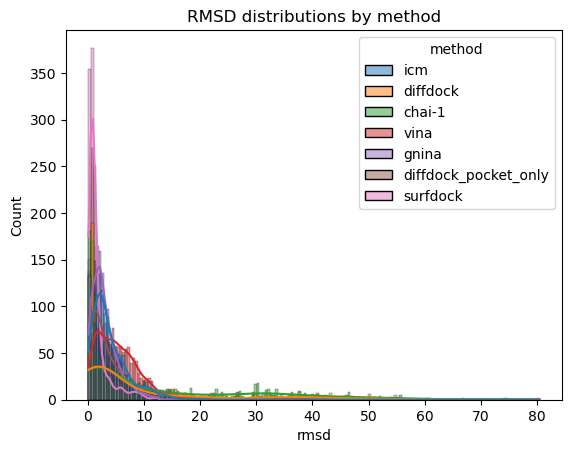

In [35]:
sns.histplot(data=df_combined, x="rmsd", hue="method", kde=True)
plt.title("RMSD distributions by method")
plt.show()

/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_66079/1941873662.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_combined, x="rmsd", hue="method", shade=True)


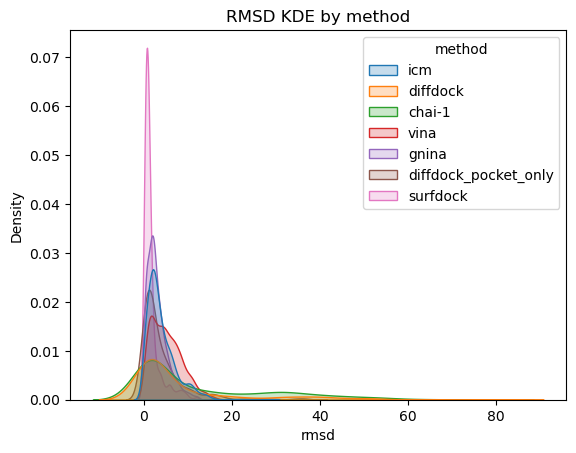

In [50]:
sns.kdeplot(data=df_combined, x="rmsd", hue="method", shade=True)
plt.title("RMSD KDE by method")
plt.show()

### absolute number of successful predictions 

In [18]:
df_combined["success"] = df_combined["rmsd_≤_2å"]
# For each protein, count how many methods succeeded
success_counts = (
    df_combined[df_combined["success"] == True]
    .groupby(["protein","method"])["success"]
    .first()  # or .any(), if multiple rows
    .unstack(fill_value=False)
)

In [19]:
# For method="icm"
print("\nAbsolute successes per method:")
for method in df_combined["method"].unique():
    method_df = df_combined[df_combined["method"] == method]
    method_success_count = success_counts[method].sum()  # Count True values
    total_proteins = method_df["protein"].nunique()  # Count unique proteins
    print(f"{method}: {method_success_count / total_proteins}.2f, {method_success_count} successes out of {total_proteins} proteins")


Absolute successes per method:
icm: 0.942652329749104.2f, 263 successes out of 279 proteins
diffdock: 0.5192307692307693.2f, 108 successes out of 208 proteins
chai-1: 0.4910394265232975.2f, 137 successes out of 279 proteins
vina: 0.5992779783393501.2f, 166 successes out of 277 proteins
gnina: 0.967741935483871.2f, 270 successes out of 279 proteins
diffdock_pocket_only: 0.5525291828793775.2f, 142 successes out of 257 proteins
surfdock: 0.899641577060932.2f, 251 successes out of 279 proteins


**Histogram for 1å, 2å, and 5å**

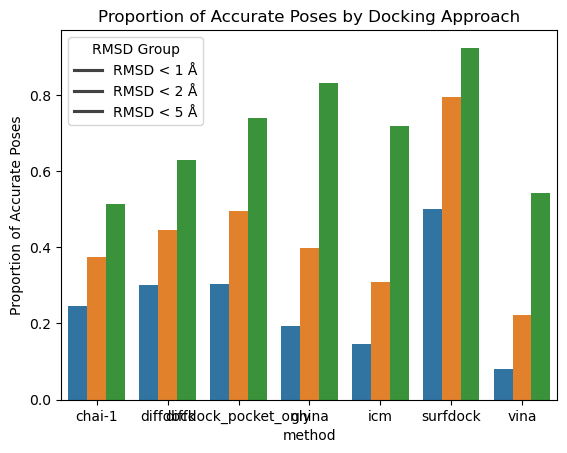

In [22]:
# Proportion of accurate poses
melted = df_combined.melt(id_vars='method', 
                        value_vars=['rmsd_≤_1å', 'rmsd_≤_2å', 'rmsd_≤_5å'],
                        var_name='RMSD_Group',
                        value_name='Is_Accurate')

prop = melted.groupby(['method', 'RMSD_Group'])['Is_Accurate'].mean().reset_index()

sns.barplot(data=prop, x='method', y='Is_Accurate', hue='RMSD_Group')
plt.ylabel('Proportion of Accurate Poses')
plt.title('Proportion of Accurate Poses by Docking Approach')
plt.legend(title='RMSD Group', labels=['RMSD < 1 Å', 'RMSD < 2 Å', 'RMSD < 5 Å'])
plt.show()


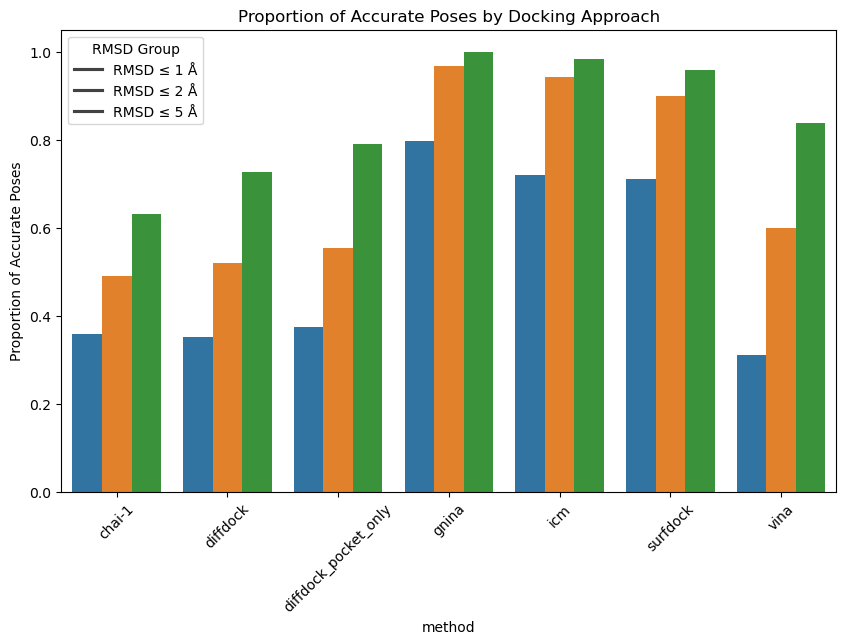

In [80]:
# Create success columns for each RMSD threshold
df_combined['success_1å'] = df_combined['rmsd_≤_1å']
df_combined['success_2å'] = df_combined['rmsd_≤_2å']
df_combined['success_5å'] = df_combined['rmsd_≤_5å']

# Group by protein and method, and check if any conformer satisfies each threshold
success_agg = df_combined.groupby(['protein', 'method']).agg({
    'success_1å': 'max',
    'success_2å': 'max',
    'success_5å': 'max'
}).reset_index()

# Melt the aggregated DataFrame for plotting
melted_success = success_agg.melt(
    id_vars=['protein', 'method'],
    value_vars=['success_1å', 'success_2å', 'success_5å'],
    var_name='RMSD_Group',
    value_name='Is_Accurate'
)

# Calculate the proportion of accurate poses
prop_success = melted_success.groupby(['method', 'RMSD_Group'])['Is_Accurate'].mean().reset_index()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(data=prop_success, x='method', y='Is_Accurate', hue='RMSD_Group')
plt.ylabel('Proportion of Accurate Poses')
plt.title('Proportion of Accurate Poses by Docking Approach')
plt.legend(title='RMSD Group', labels=['RMSD ≤ 1 Å', 'RMSD ≤ 2 Å', 'RMSD ≤ 5 Å'])
plt.xticks(rotation=45)
plt.show()

### Cumulative Plots for the RMSD

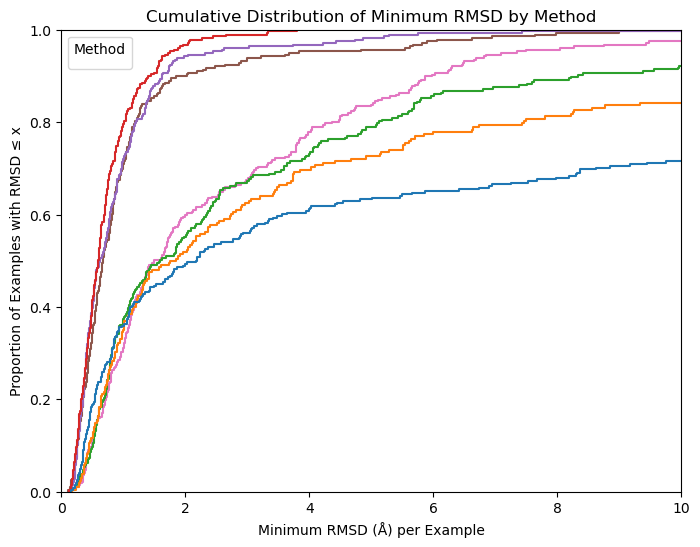

In [46]:
# Group by method and example, and compute the minimum RMSD among the multiple conformations
df_min_rmsd = (
    df_combined
    .groupby(["method", "protein"], as_index=False)["rmsd"]
    .min()
    .rename(columns={"rmsd": "min_rmsd"})
)

plt.figure(figsize=(8, 6))

# Plot the ECDF for min_rmsd by method, capturing the Axes object
ax = sns.ecdfplot(
    data=df_min_rmsd,
    x="min_rmsd",
    hue="method"
)

plt.xlabel("Minimum RMSD (Å) per Example")
plt.xlim(0, 10)
plt.ylabel("Proportion of Examples with RMSD ≤ x")
plt.title("Cumulative Distribution of Minimum RMSD by Method")

# Manually fetch the handles and labels from the Axes
handles, labels = ax.get_legend_handles_labels()

# Then create the legend manually
plt.legend(handles, labels, title="Method", loc="best")

plt.show()

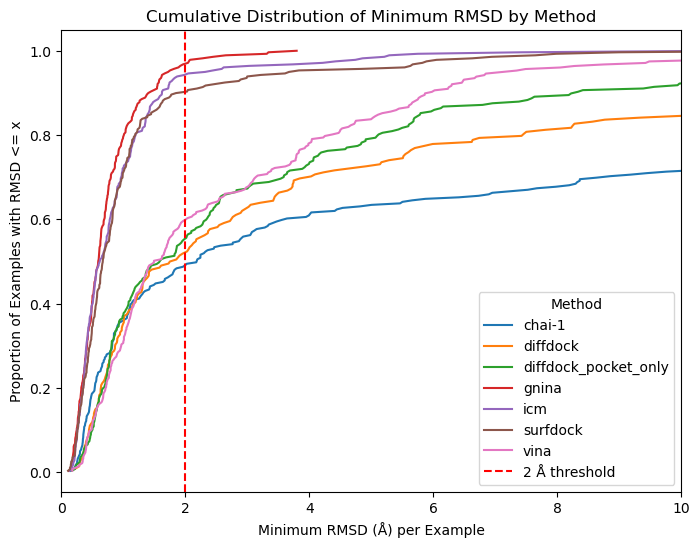

In [65]:
# Identify the unique docking methods
methods = df_min_rmsd["method"].unique()
plt.figure(figsize=(8, 6))

for m in methods:
    # Filter the data for this method
    subset = df_min_rmsd[df_min_rmsd["method"] == m]["min_rmsd"].values
    # Sort min_rmsd
    sorted_vals = np.sort(subset)
    # Compute the empirical CDF
    yvals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    # Plot the curve
    plt.plot(sorted_vals, yvals, label=m)

plt.axvline(x=2, color='red', linestyle='--', label='2 Å threshold')
plt.xlabel("Minimum RMSD (Å) per Example")
plt.xlim(0, 10)
plt.ylabel("Proportion of Examples with RMSD <= x")
plt.title("Cumulative Distribution of Minimum RMSD by Method")
plt.legend(title="Method", loc="best")
plt.show()

In [ ]:
### deprecaated because scaling
for group, label in zip(['rmsd_≤_1å', 'rmsd_≤_2å', 'rmsd_≤_5å'], 
                        ['rmsd_≤_1å', 'rmsd_≤_2å', 'rmsd_≤_5å']):
    subset = df_combined[df_combined[group]]
    sns.scatterplot(data=subset, x='score', y='rmsd', hue='method')
    plt.title(f'Scatter Plot for {label}')
    plt.show()

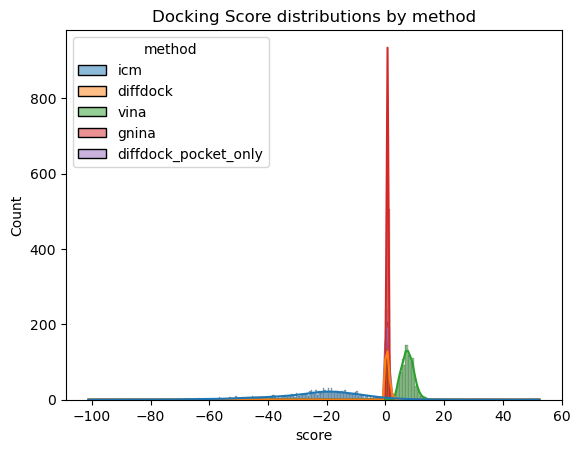

In [35]:
sns.histplot(data=df_combined.dropna(subset=["score"]), x="score", hue="method", kde=True)
plt.title("Docking Score distributions by method")
plt.show()

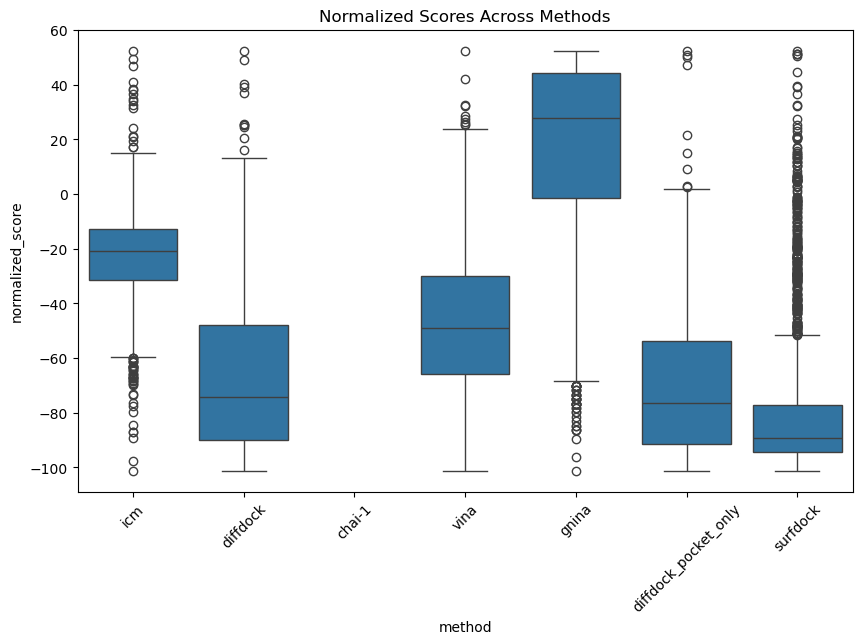

In [26]:
# Get ICM score range for scaling reference
icm_min = df_combined[df_combined['method'] == 'icm']['score'].min()
icm_max = df_combined[df_combined['method'] == 'icm']['score'].max()

# Create normalized scores column
def normalize_to_icm_scale(group):
    method = group['method'].iloc[0]
    if method == 'icm':
        return group['score']
    else:
        # Min-max normalization scaled to ICM range
        method_min = group['score'].min()
        method_max = group['score'].max()
        return (group['score'] - method_min) * (icm_max - icm_min) / (method_max - method_min) + icm_min

# Apply normalization
df_combined['normalized_score'] = df_combined.groupby('method').apply(normalize_to_icm_scale).reset_index(level=0, drop=True)

# Plot comparison
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x='method', y='normalized_score')
plt.title('Normalized Scores Across Methods')
plt.xticks(rotation=45)
plt.show()

**Confidence/Score histograms**

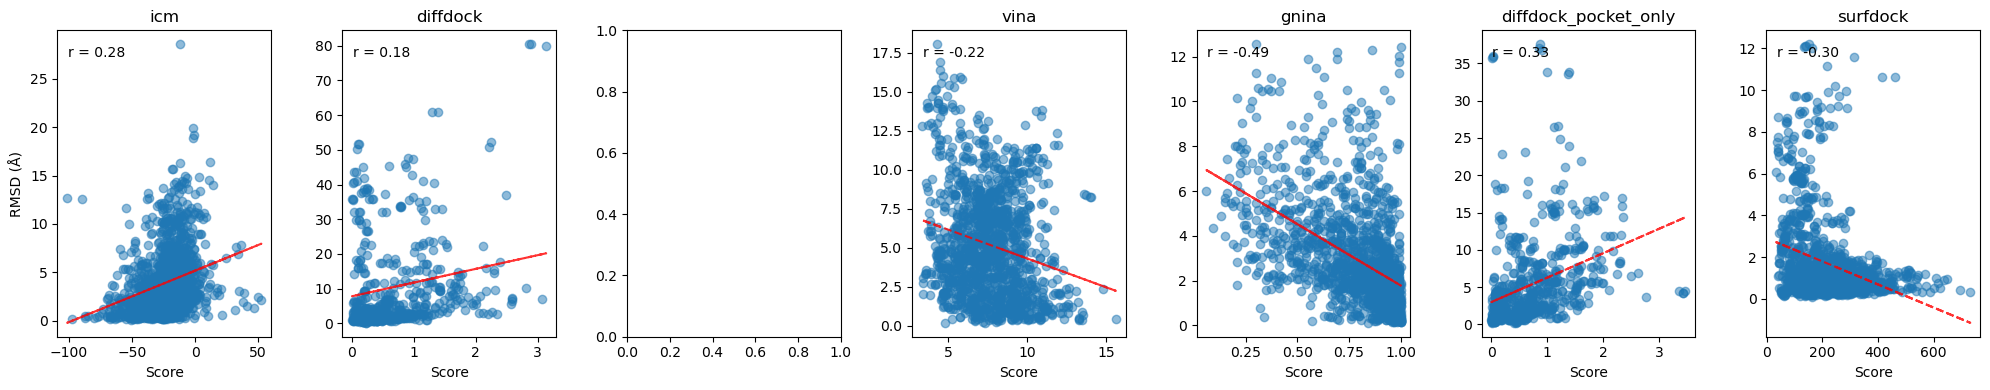

In [26]:
# Create a figure with subplots for each method
methods = df_combined['method'].unique()
n_methods = len(methods)
fig, axes = plt.subplots(1, n_methods, figsize=(20, 4))

for idx, method in enumerate(methods):
    if method == 'chai-1':
        continue
    method_data = df_combined[df_combined['method'] == method].dropna(subset=['score'])
    
    # Create scatter plot
    axes[idx].scatter(method_data['score'], method_data['rmsd'], alpha=0.5)
    
    # Add regression line
    z = np.polyfit(method_data['score'], method_data['rmsd'], 1)
    p = np.poly1d(z)
    axes[idx].plot(method_data['score'], p(method_data['score']), "r--", alpha=0.8)
    
    # Customize subplot
    axes[idx].set_title(f'{method}')
    axes[idx].set_xlabel('Score')
    axes[idx].set_ylabel('RMSD (Å)' if idx == 0 else '')
    
    # Add correlation coefficient
    corr = method_data['score'].corr(method_data['rmsd'])
    axes[idx].text(0.05, 0.95, f'r = {corr:.2f}', 
                  transform=axes[idx].transAxes, 
                  verticalalignment='top')

plt.tight_layout()
plt.show()

In [45]:
methods = df_combined.dropna(subset=["score"])["method"].unique()

for m in methods:
    subset = df_combined[(df_combined["method"] == m) & (df_combined["score"].notna())]
    fig = px.scatter(
        subset,
        x="score",
        y="rmsd",
        color="rmsd_≤_2å",
        title=f"RMSD vs Score for {m}",
        width=800,
        height=600
    )
    fig.show()

### Statistical analysis for RMSD and score 

In [43]:
from scipy.stats import pearsonr, spearmanr
for method in df_combined['method'].unique():
    if method == 'chai-1':
        continue
    for group in 'rmsd_≤_1å', 'rmsd_≤_2å', 'rmsd_≤_5å':
        subset = df_combined[(df_combined['method'] == method) & (df_combined[group])]
        # Filter out NaN/Inf values before correlation
        subset_clean = subset.dropna(subset=['score', 'rmsd'])
        subset_clean = subset_clean[~subset_clean.isin([np.inf, -np.inf]).any(axis=1)]
        # print(f"{method} {group} accuracy: {df_combined[(df_combined['method']==method.mean())]:.3f}")
        # corr = subset_clean['rmsd'].corr(subset_clean['score'])
        pearson_corr, pearson_p = pearsonr(subset_clean['score'], subset_clean['rmsd'])
        spearman_corr, spearman_p = spearmanr(subset_clean['score'], subset_clean['rmsd'])

        print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {pearson_p:.3f}")
        print(f"Spearman Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")
        # print(f"{method} correlation for {group}: {corr:.3f}")

        # Scatter Plots
        # sns.scatterplot(x='rmsd', y='score', hue='method', data=subset)
        # plt.title('RMSD vs. Score by Docking Method')
        # plt.show()

        # linear regreesion 
    subset = (df_combined[(df_combined['method']==method)])
    subset = subset.dropna(subset=['score', 'rmsd'])
    subset = subset[~subset.isin([np.inf, -np.inf]).any(axis=1)]    
    corr = subset['rmsd'].corr(subset['score'])
    pearson_corr, pearson_p = pearsonr(subset['score'], subset['rmsd'])
    spearman_corr, spearman_p = spearmanr(subset['score'], subset['rmsd'])
    
    print(f"{method} overall correlation: ")
    print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {pearson_p:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")


Pearson Correlation: 0.158, p-value: 0.024
Spearman Correlation: 0.147, p-value: 0.036
Pearson Correlation: 0.264, p-value: 0.000
Spearman Correlation: 0.271, p-value: 0.000
Pearson Correlation: 0.286, p-value: 0.000
Spearman Correlation: 0.303, p-value: 0.000
icm overall correlation: 
Pearson Correlation: 0.277, p-value: 0.000
Spearman Correlation: 0.352, p-value: 0.000
Pearson Correlation: 0.259, p-value: 0.052
Spearman Correlation: 0.158, p-value: 0.239
Pearson Correlation: 0.330, p-value: 0.000
Spearman Correlation: 0.383, p-value: 0.000
Pearson Correlation: 0.272, p-value: 0.000
Spearman Correlation: 0.276, p-value: 0.000
diffdock overall correlation: 
Pearson Correlation: 0.181, p-value: 0.000
Spearman Correlation: 0.241, p-value: 0.000
Pearson Correlation: 0.026, p-value: 0.789
Spearman Correlation: 0.042, p-value: 0.664
Pearson Correlation: -0.215, p-value: 0.000
Spearman Correlation: -0.191, p-value: 0.001
Pearson Correlation: -0.315, p-value: 0.000
Spearman Correlation: -0.31

**Correlations among numeric columns:**

## PB Validity Plotting

In [144]:
BUST_TEST_COLUMNS = [
    # accuracy #
    "rmsd_≤_2å",
    # chemical validity and consistency #
    "mol_pred_loaded",
    "mol_true_loaded",
    "mol_cond_loaded",
    "sanitization",
    "molecular_formula",
    "molecular_bonds",
    "tetrahedral_chirality",
    "double_bond_stereochemistry",
    # intramolecular validity #
    "bond_lengths",
    "bond_angles",
    "internal_steric_clash",
    "aromatic_ring_flatness",
    "double_bond_flatness",
    "internal_energy",
    # intermolecular validity #
    "minimum_distance_to_protein",
    "minimum_distance_to_organic_cofactors",
    "minimum_distance_to_inorganic_cofactors",
    "volume_overlap_with_protein",
    "volume_overlap_with_organic_cofactors",
    "volume_overlap_with_inorganic_cofactors",
]

In [58]:
# Drop rows with NaN in the 'rmsd' column
# Show the rows that contain NaN in 'rmsd' column
# df_nan = df_combined[df_combined["rmsd"].isna()]
# print(df_nan) # 7ZHP_IQY from Chai-1 is missing

df_combined_no_na = df_combined.dropna(subset=["rmsd"])
print(df_combined_no_na.shape, df_combined.shape)

df_best = df_combined_no_na.loc[
    df_combined_no_na.groupby(["method","protein"])["rmsd"].idxmin()
].reset_index(drop=True)
df_best.shape

(9240, 133) (9245, 133)


(1857, 133)

In [61]:
print(df_min_rmsd[(df_min_rmsd['protein'] == '5SAK_ZRY')])
print(df_best[(df_best['protein'] == '5SAK_ZRY')][['method', 'rmsd']])

                    method   protein  min_rmsd
0                   chai-1  5SAK_ZRY  0.935259
279               diffdock  5SAK_ZRY  0.684621
487   diffdock_pocket_only  5SAK_ZRY  0.802583
744                  gnina  5SAK_ZRY  0.197836
1023                   icm  5SAK_ZRY  0.791606
1302              surfdock  5SAK_ZRY  0.346528
1581                  vina  5SAK_ZRY  0.342959
                    method      rmsd
0                   chai-1  0.935259
278               diffdock  0.684621
486   diffdock_pocket_only  0.802583
743                  gnina  0.197836
1022                   icm  0.791606
1301              surfdock  0.346528
1580                  vina  0.342959


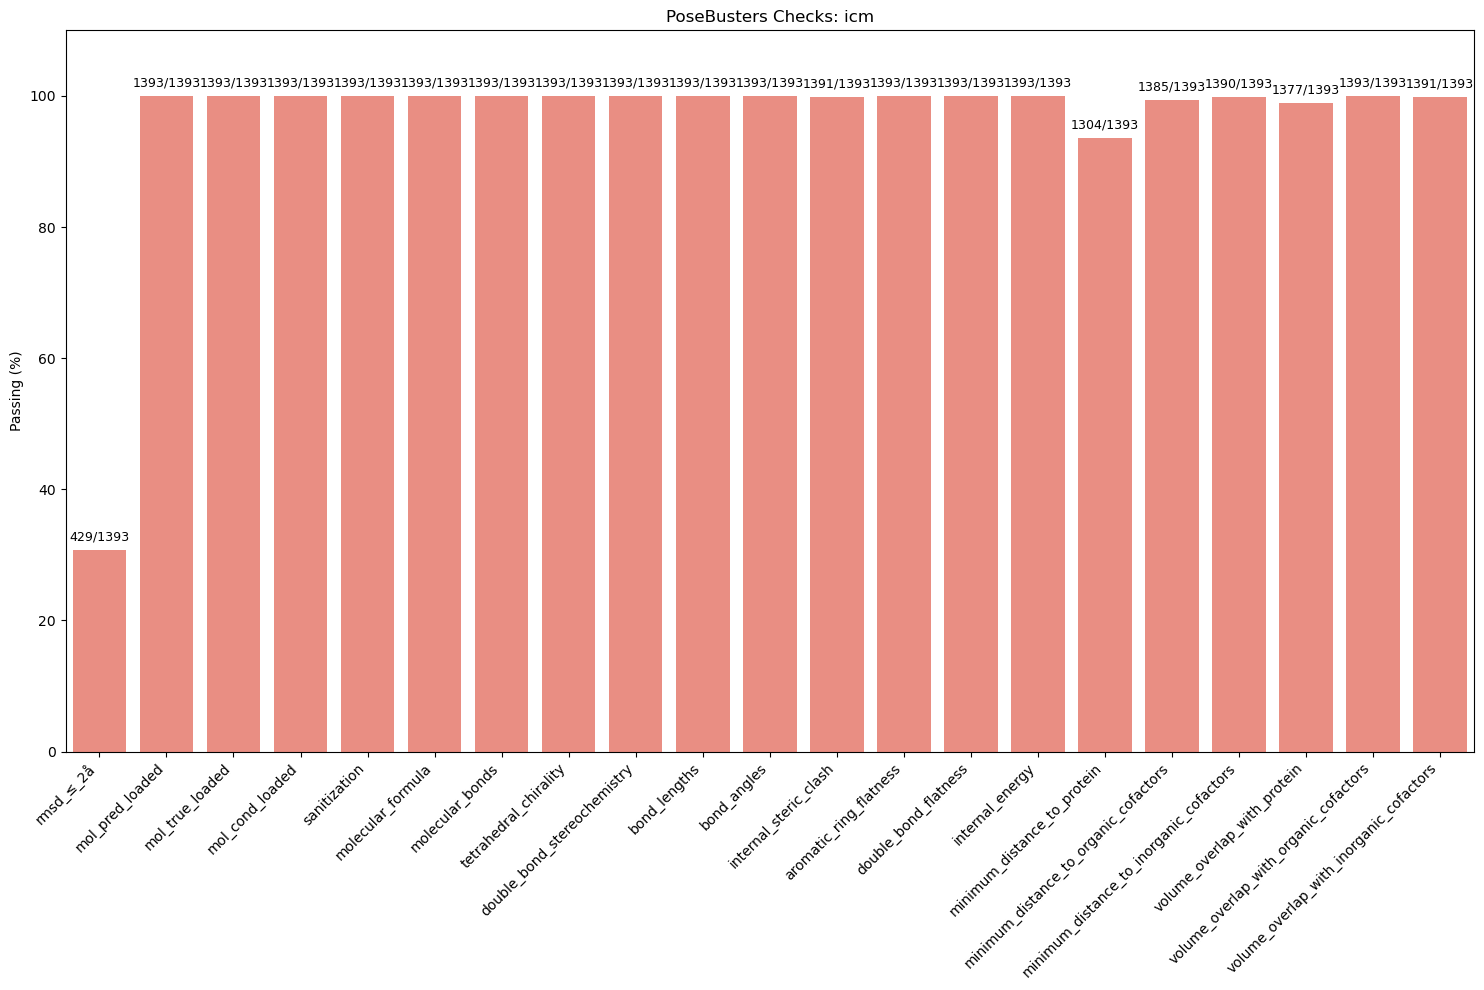

In [43]:
def plot_single_approach_posebusters(df, approach_name, test_cols=BUST_TEST_COLUMNS):
    # Count how many total conformations
    total = len(df)

    # Calculate pass proportion for each test
    results = []
    for col in test_cols:
        pass_count = df[col].sum()  # assuming booleans or 0/1
        prop = pass_count / total if total else 0.0
        results.append((col, pass_count, total, prop))

    # Convert to DataFrame
    prop_df = pd.DataFrame(results, columns=["test", "pass_count", "total", "proportion"])
    prop_df["percentage"] = 100.0 * prop_df["proportion"]

    # Sort or keep the test_cols order
    prop_df["test"] = pd.Categorical(prop_df["test"], categories=test_cols, ordered=True)
    prop_df.sort_values("test", inplace=True)

    # Plot
    plt.figure(figsize=(15, 10))
    sns.barplot(data=prop_df, x="test", y="percentage", color="salmon")
    plt.ylim(0, 110)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("Passing (%)")
    plt.title(f"PoseBusters Checks: {approach_name}")
    
    # Annotate each bar with pass_count / total
    ax = plt.gca()
    for i, row in prop_df.iterrows():
        ax.text(i, row["percentage"] + 1,
                f"{int(row['pass_count'])}/{int(row['total'])}",
                ha="center", va="bottom", fontsize=9)
        
    plt.tight_layout()
    plt.show()

plot_single_approach_posebusters(df_combined[(df_combined.method == 'icm')], approach_name="icm")

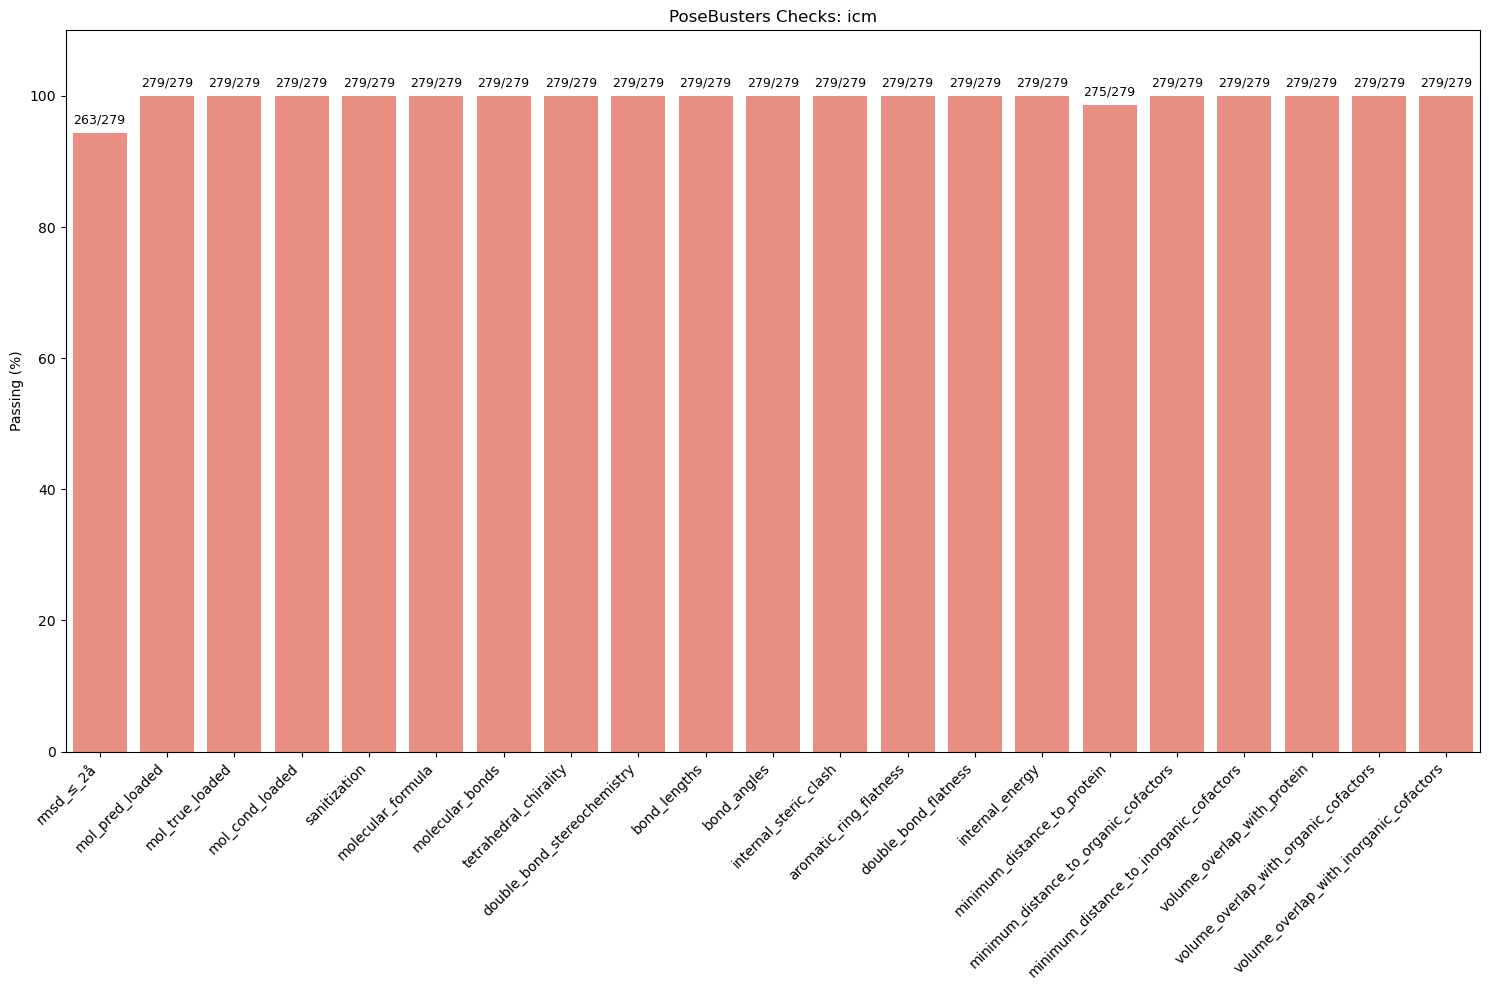

In [62]:
plot_single_approach_posebusters(df_best[(df_best.method == 'icm')], approach_name="icm")

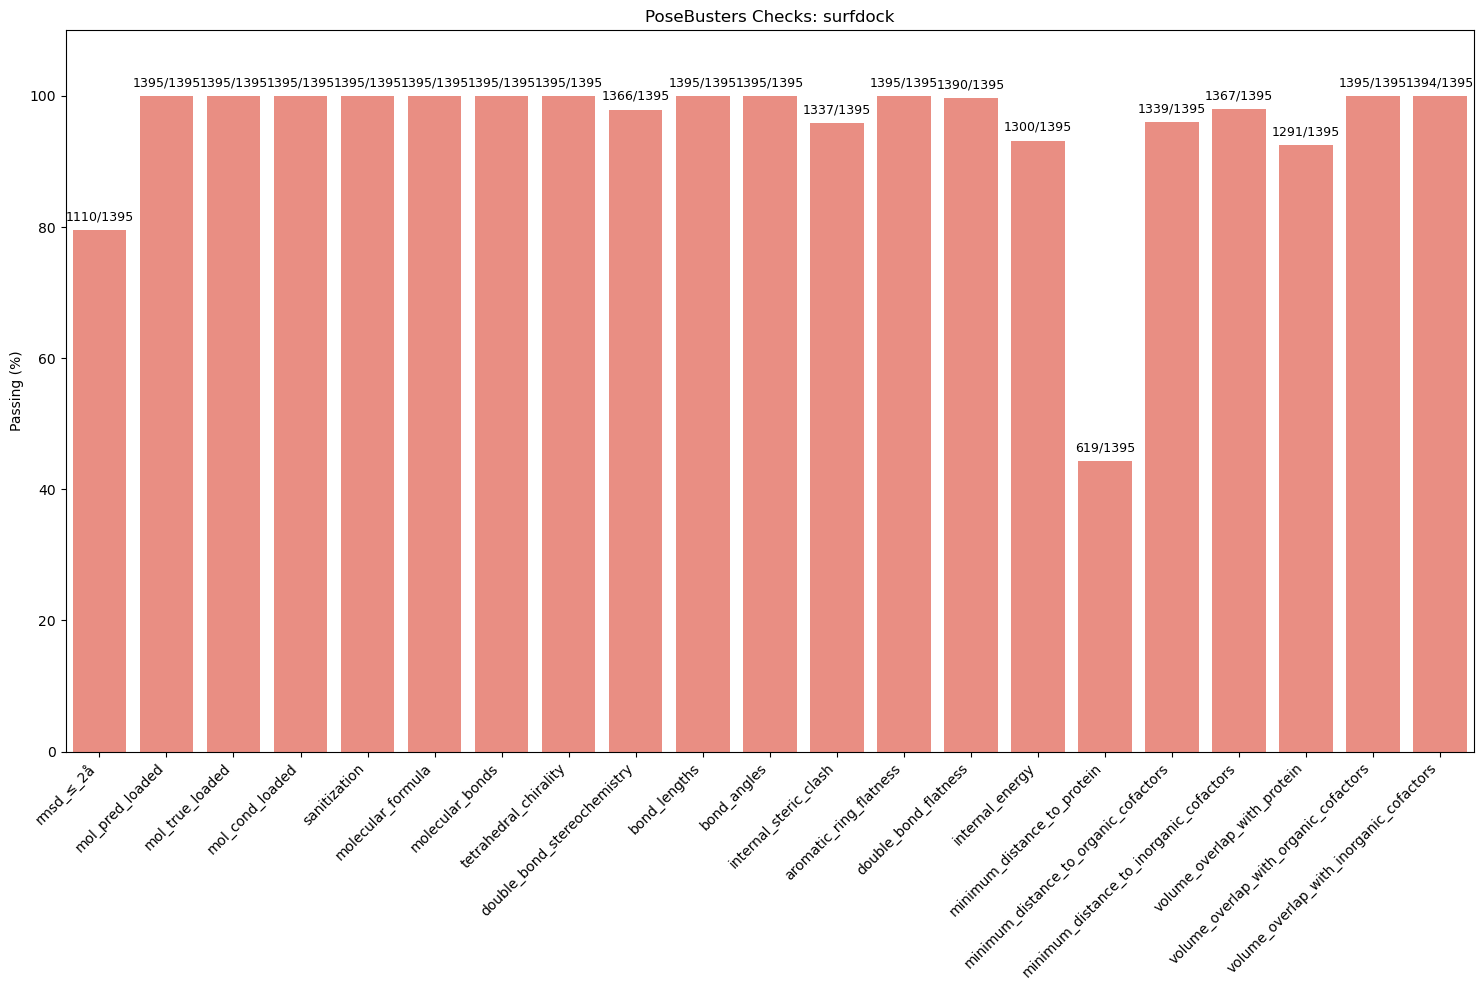

In [44]:
plot_single_approach_posebusters(df_combined[(df_combined.method == 'surfdock')], approach_name="surfdock")

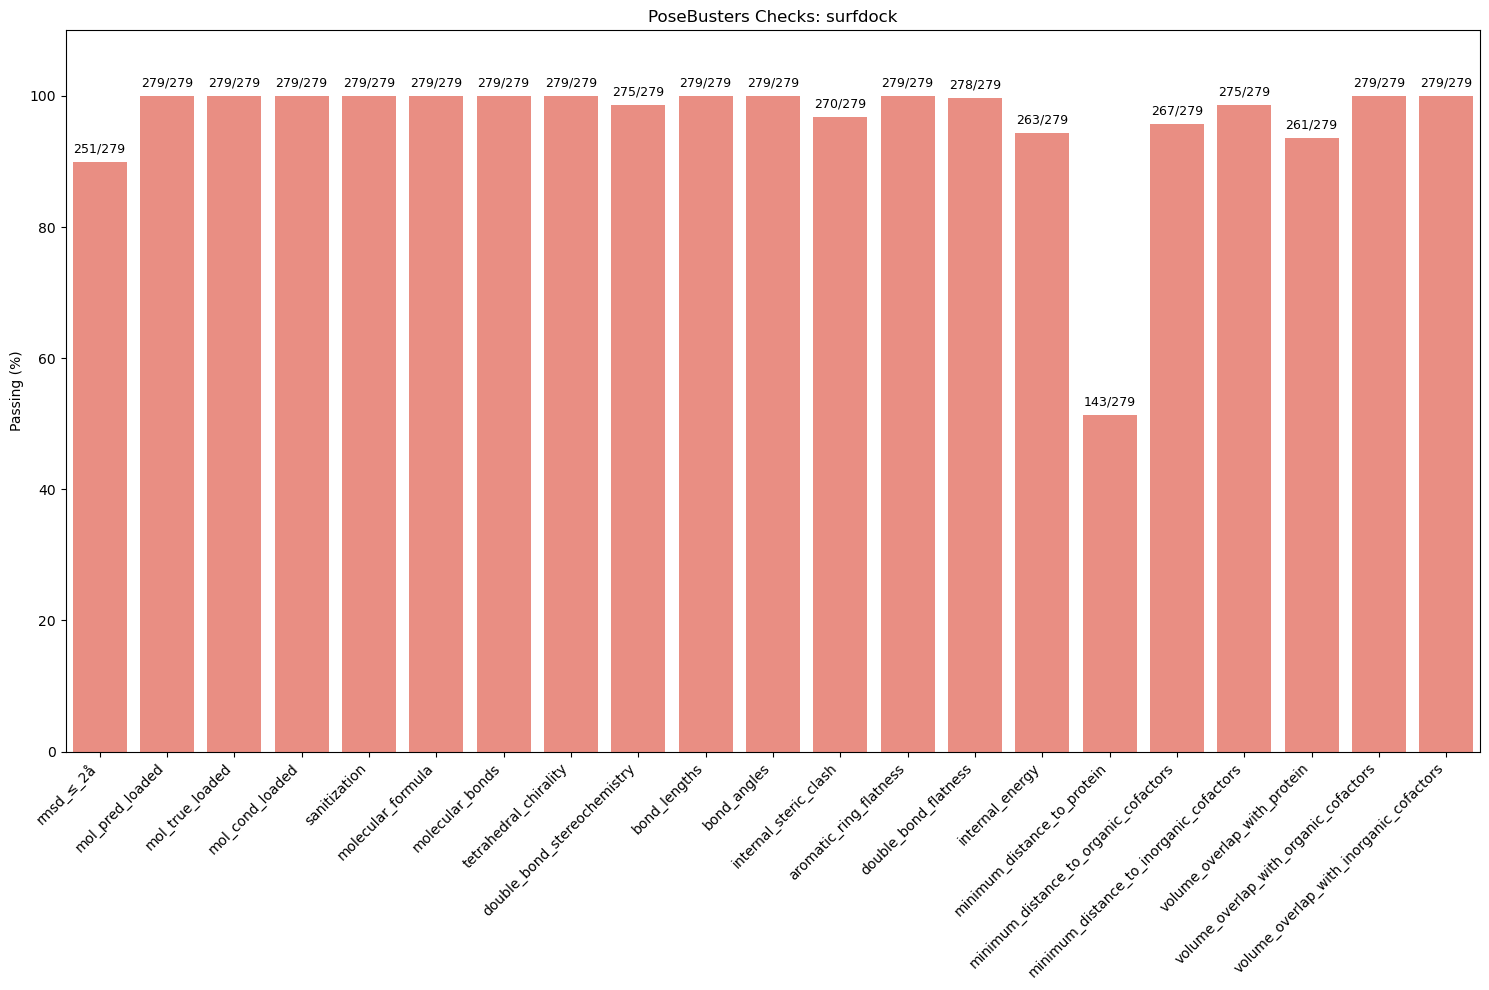

In [63]:
plot_single_approach_posebusters(df_best[(df_best.method == 'surfdock')], approach_name="surfdock")

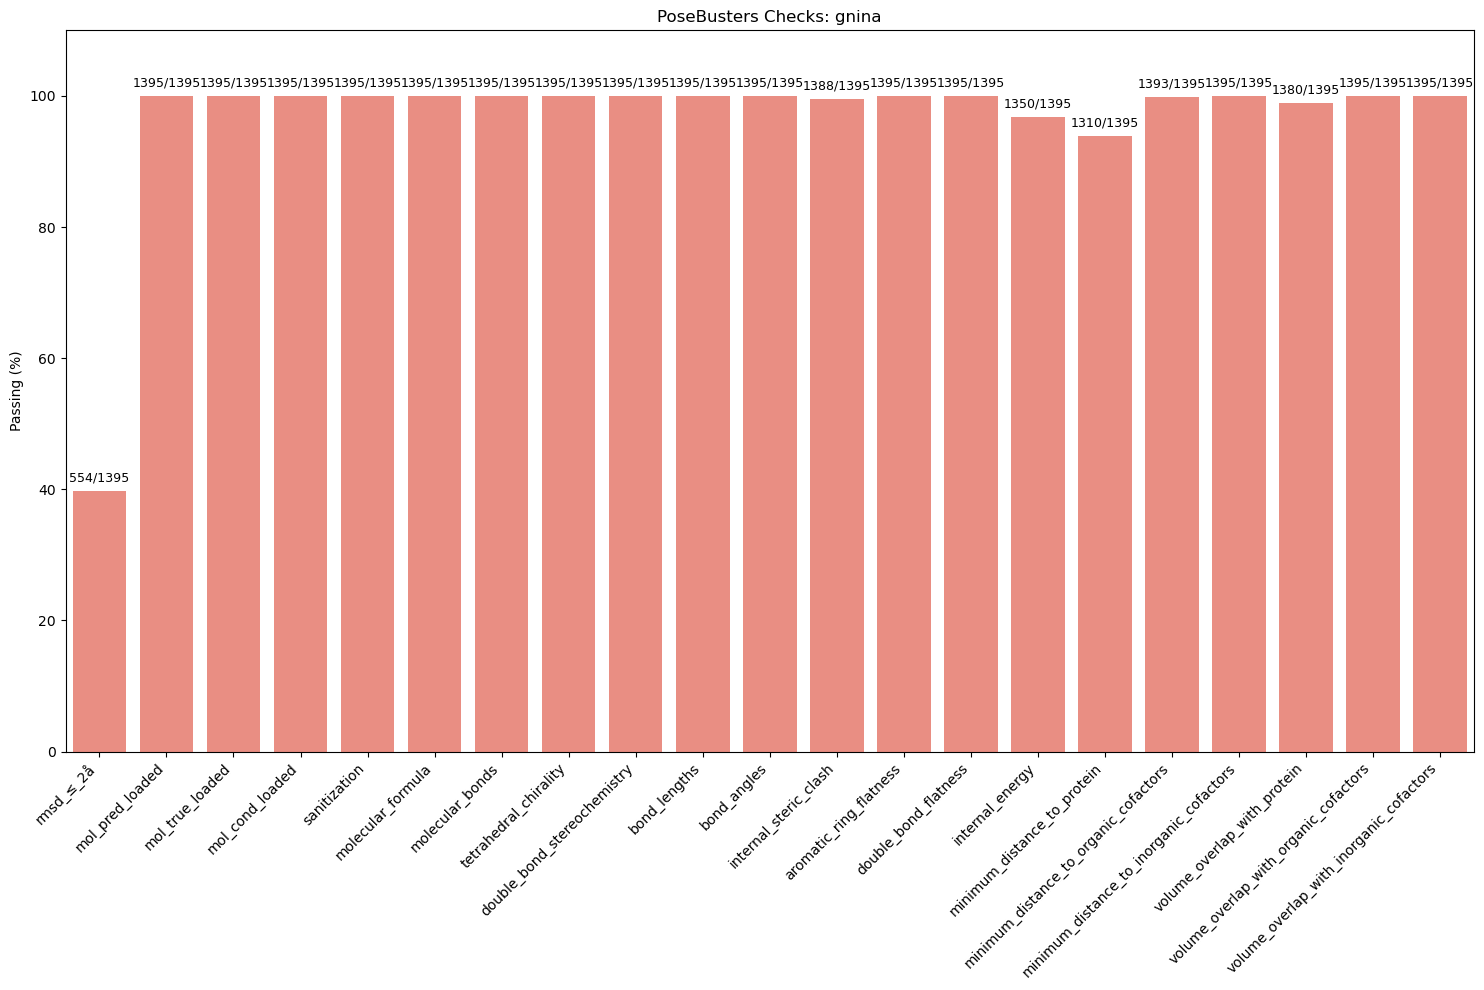

In [45]:
plot_single_approach_posebusters(df_combined[(df_combined.method == 'gnina')], approach_name="gnina")

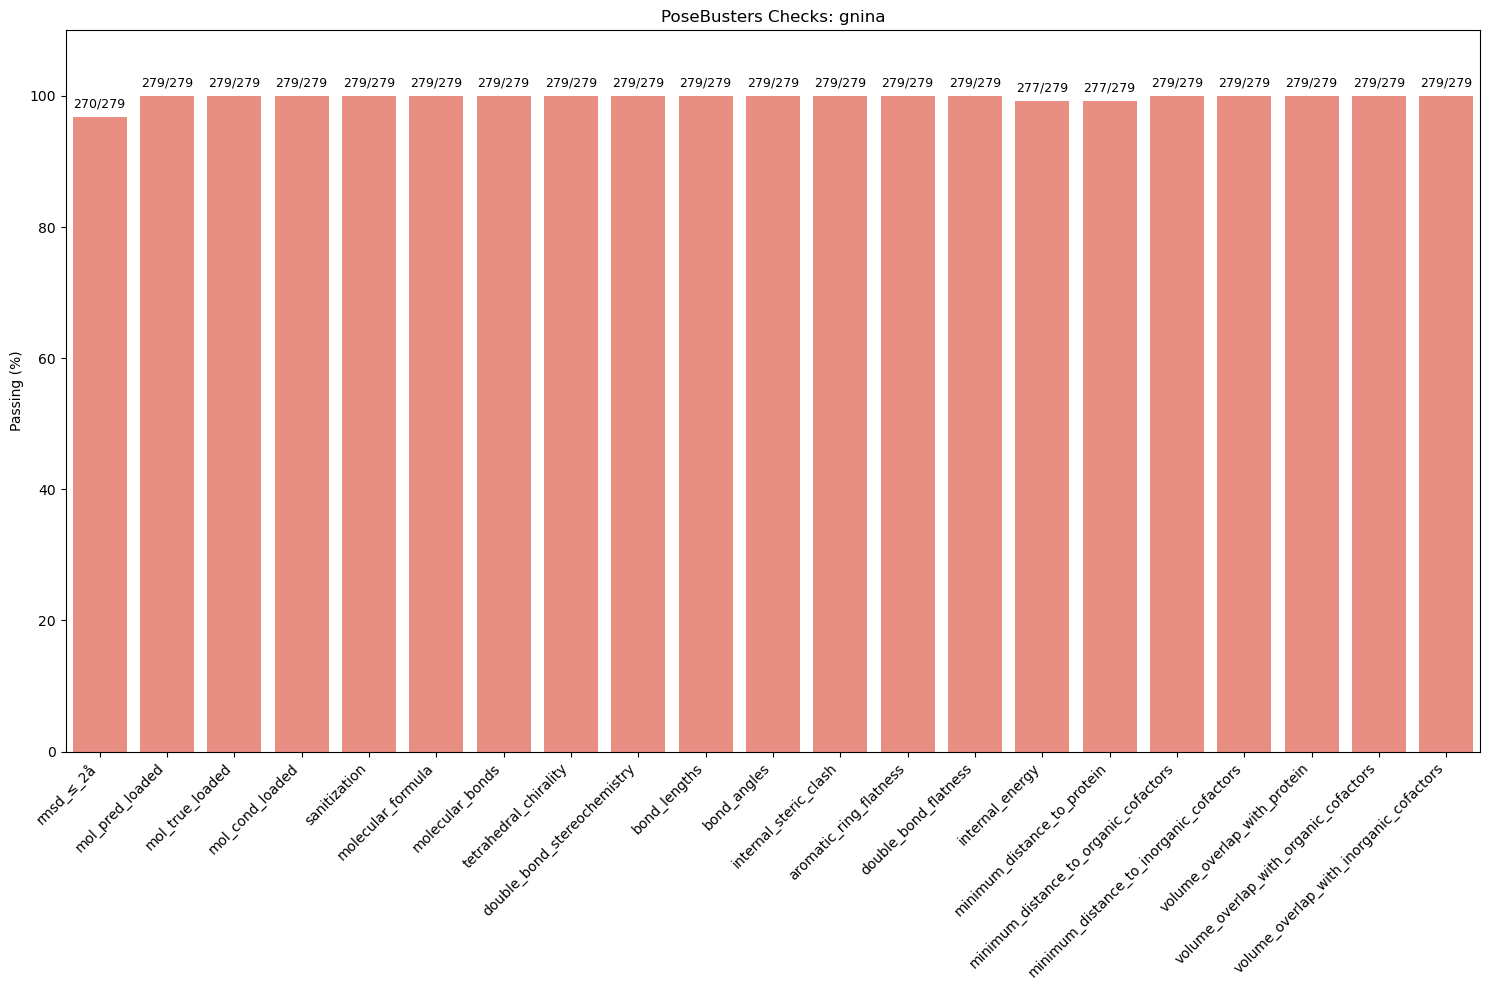

In [66]:
plot_single_approach_posebusters(df_best[(df_best.method == 'gnina')], approach_name="gnina")

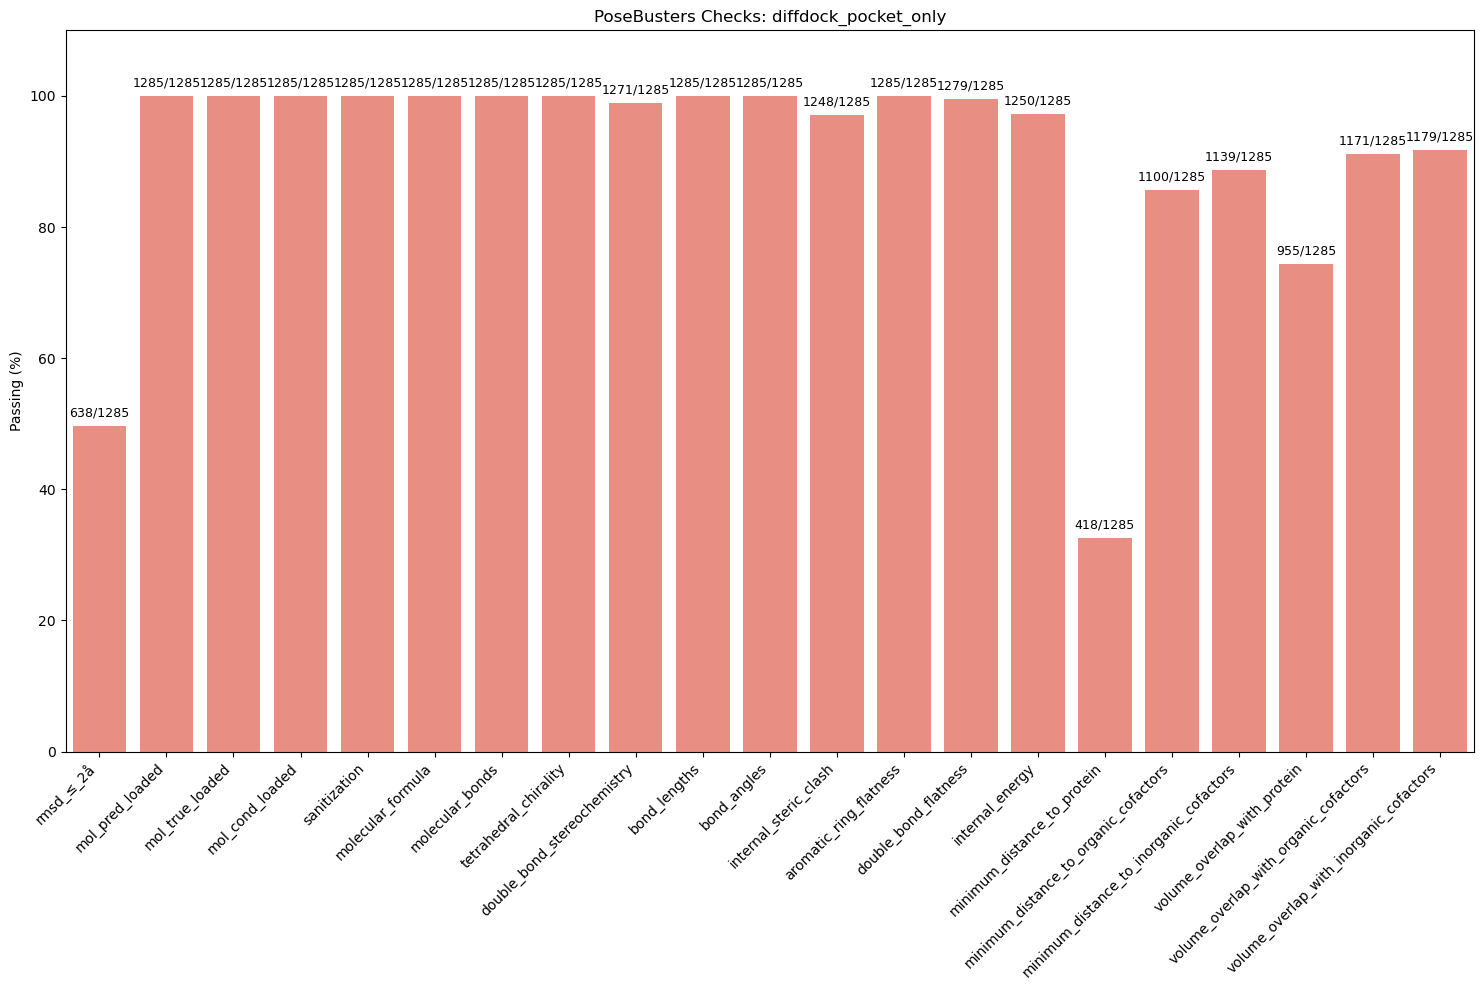

In [111]:
plot_single_approach_posebusters(df_combined[(df_combined.method == 'diffdock_pocket_only')], approach_name="diffdock_pocket_only")

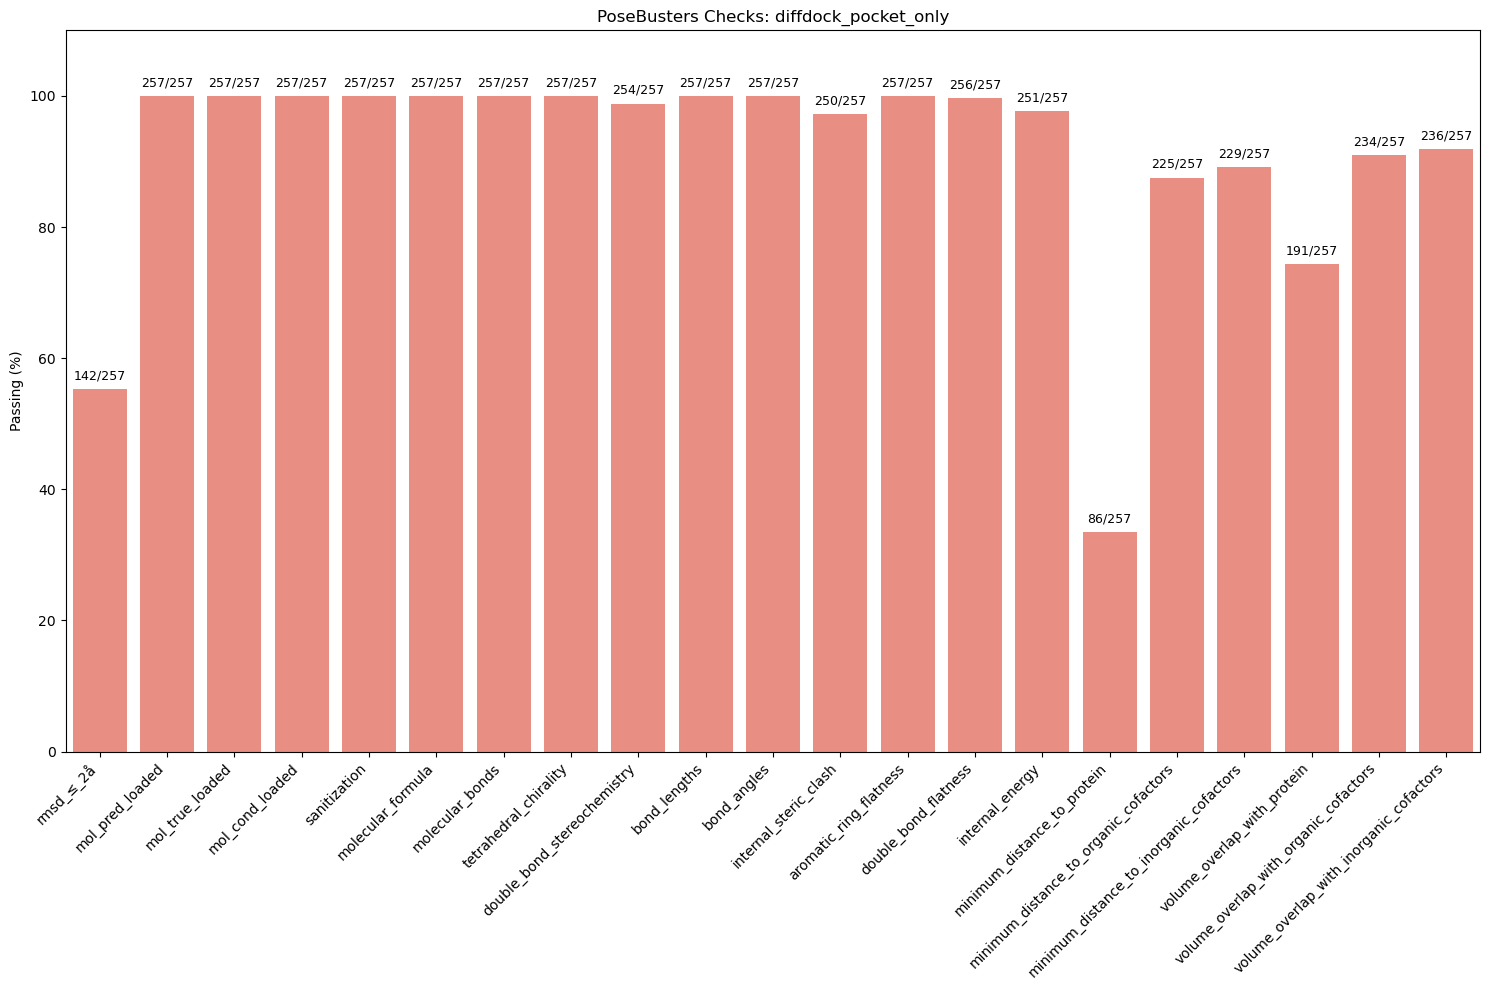

In [112]:
plot_single_approach_posebusters(df_best[(df_best.method == 'diffdock_pocket_only')], approach_name="diffdock_pocket_only")

**Q: does fail in pb validity check -> large RMSD?**

In [103]:
def split_by_boolean(df, bool_col, numeric_col):
    """
    Return two Series: x_pass, x_fail
      - x_pass: numeric_col values where bool_col == True
      - x_fail: numeric_col values where bool_col == False
    Also drops NaN for cleanliness.
    """
    x_pass = df.loc[df[bool_col] == True,  numeric_col].dropna()
    x_fail = df.loc[df[bool_col] == False, numeric_col].dropna()
    return x_pass, x_fail


def plot_boxplot_boolean_numeric(df, bool_col, numeric_col, ax=None):
    """
    Create a boxplot comparing numeric_col for pass vs. fail in bool_col.
    If ax is None, create a new figure+axes.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
    
    sns.boxplot(
        data=df, 
        x=bool_col, 
        y=numeric_col, 
        ax=ax
    )
    ax.set_title(f"{numeric_col} by {bool_col}")
    ax.set_xlabel(f"{bool_col} (False/True)")
    ax.set_ylabel(numeric_col)
    
    return ax  # Return the axes for further customization if needed


from scipy.stats import mannwhitneyu, pointbiserialr

def mann_whitney_test(x_pass, x_fail):
    """
    Perform Mann-Whitney U test on two numeric arrays x_pass vs x_fail.
    Returns (stat, pvalue). If one group is empty, return (None, None).
    """
    if len(x_pass) > 0 and len(x_fail) > 0:
        stat, pval = mannwhitneyu(x_pass, x_fail, alternative="two-sided")
        return stat, pval
    return None, None

def point_biserial(df, bool_col, numeric_col):
    """
    Compute point-biserial correlation between bool_col (boolean) and numeric_col.
    Returns (corr, pval). If not enough data, returns (None, None).
    """
    # convert bool -> 0/1
    y_bool = df[bool_col].astype(int)
    x_num  = df[numeric_col]
    mask = x_num.notna()
    
    if mask.sum() < 2:
        return None, None
    
    corr, pval = pointbiserialr(y_bool[mask], x_num[mask])
    return corr, pval

In [104]:
def analyze_boolean_numeric_pair(df, bool_col, numeric_col, plot=True):
    """
    Analyze how numeric_col differs based on bool_col pass/fail.
    - Plots a boxplot if plot=True.
    - Computes Mann-Whitney and point-biserial correlation.
    Returns a dict with results.
    """
    # Split data
    x_pass, x_fail = split_by_boolean(df, bool_col, numeric_col)

    # Plot if desired
    ax = None
    if plot:
        ax = plot_boxplot_boolean_numeric(df, bool_col, numeric_col)
        plt.show()

    # Mann-Whitney
    mw_stat, mw_p = mann_whitney_test(x_pass, x_fail)

    # Point-biserial
    corr, corr_p = point_biserial(df, bool_col, numeric_col)

    # Prepare a summary
    results = {
        "bool_col": bool_col,
        "numeric_col": numeric_col,
        "mannwhitney_stat": mw_stat,
        "mannwhitney_p": mw_p,
        "pointbiserial_corr": corr,
        "pointbiserial_p": corr_p,
        "n_pass": len(x_pass),
        "n_fail": len(x_fail),
    }
    return results

In [105]:
def run_boolean_numeric_pipeline(
    df, 
    boolean_checks, 
    numeric_columns, 
    do_plots=False
):
    """
    For each bool_col in boolean_checks, and each numeric_col in numeric_columns,
    call analyze_boolean_numeric_pair, collect stats in a DataFrame.
    If do_plots=True, show the boxplots as well.
    """
    all_results = []

    for bool_col in boolean_checks:
        for numeric_col in numeric_columns:
            res = analyze_boolean_numeric_pair(
                df, bool_col, numeric_col, plot=do_plots
            )
            all_results.append(res)

    # Convert list of dicts into a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

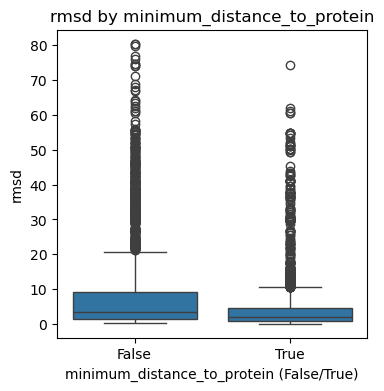

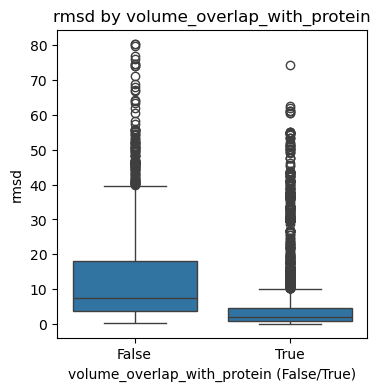

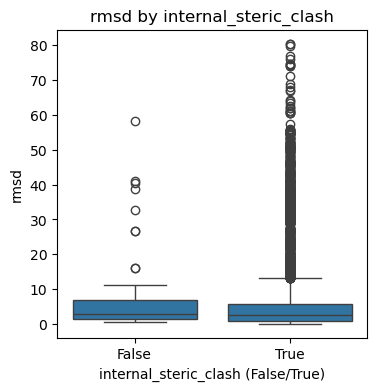

,bool_col,numeric_col,mannwhitney_stat,mannwhitney_p,pointbiserial_corr,pointbiserial_p,n_pass,n_fail
0,minimum_distance_to_protein,rmsd,7336514.0,6.668543e-109,-0.242140,2.136165e-123,5688,3552
1,volume_overlap_with_protein,rmsd,2189121.0,0.000000e+00,-0.389288,0.000000e+00,7733,1507
2,internal_steric_clash,rmsd,651904.0,3.570266e-02,0.003344,7.478881e-01,9081,159


In [113]:
results_df = run_boolean_numeric_pipeline(
    df_combined,
    ["minimum_distance_to_protein", "volume_overlap_with_protein", "internal_steric_clash"],
    ["rmsd"],
    do_plots=True
)
results_df

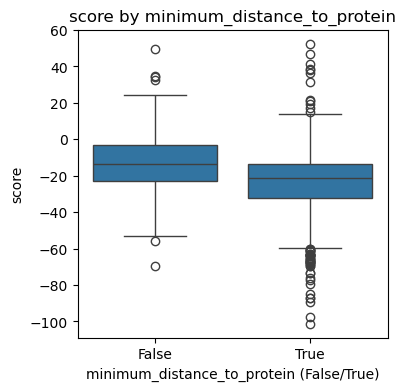

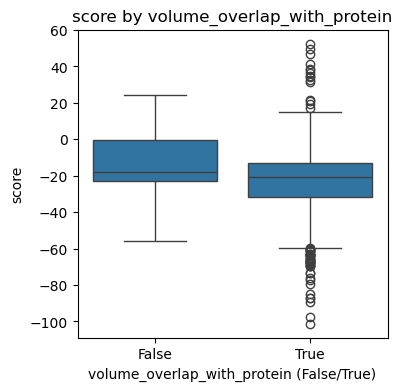

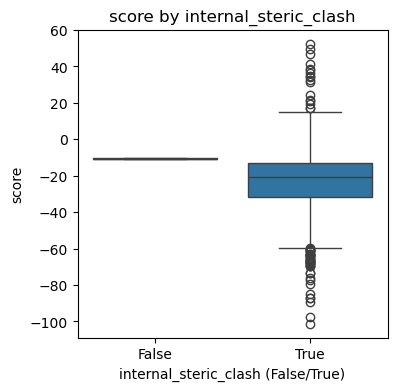

,bool_col,numeric_col,mannwhitney_stat,mannwhitney_p,pointbiserial_corr,pointbiserial_p,n_pass,n_fail
0,minimum_distance_to_protein,score,38758.0,1.537386e-07,-0.150776,1.561287e-08,1304,89
1,volume_overlap_with_protein,score,8385.0,1.001224e-01,-0.049804,6.312217e-02,1377,16
2,internal_steric_clash,score,565.0,1.657961e-01,-0.026929,3.152170e-01,1391,2


In [116]:
run_boolean_numeric_pipeline(
    df_combined[df_combined['method'] == 'icm'],
    ["minimum_distance_to_protein", "volume_overlap_with_protein", "internal_steric_clash"],
    ["score"],
    do_plots=True
)

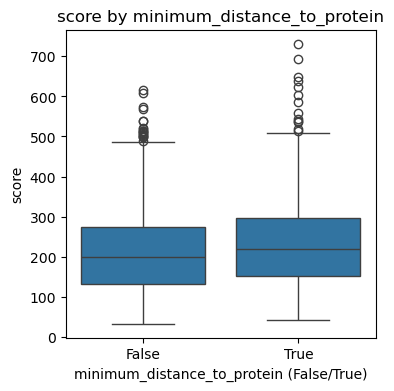

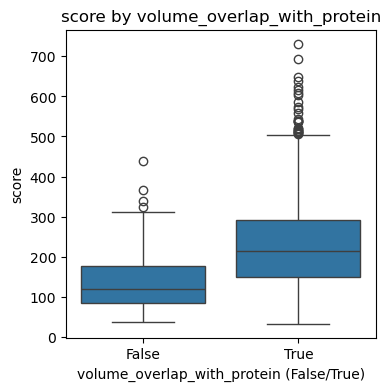

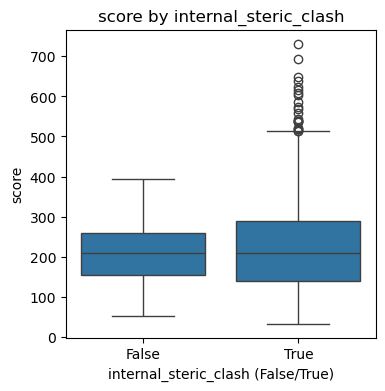

,bool_col,numeric_col,mannwhitney_stat,mannwhitney_p,pointbiserial_corr,pointbiserial_p,n_pass,n_fail
0,minimum_distance_to_protein,score,263207.0,2.060177e-03,0.071648,7.426454e-03,619,776
1,volume_overlap_with_protein,score,103068.0,9.662903e-20,0.220742,7.408445e-17,1291,104
2,internal_steric_clash,score,41945.0,2.910026e-01,0.041667,1.198235e-01,1337,58


In [117]:
run_boolean_numeric_pipeline(
    df_combined[df_combined['method'] == 'surfdock'],
    ["minimum_distance_to_protein", "volume_overlap_with_protein", "internal_steric_clash"],
    ["score"],
    do_plots=True
)

In [83]:
pass_mask = df_combined_no_na["minimum_distance_to_protein"]  # True/False
fail_mask = ~pass_mask
#### Visual analysis
print(df_combined.columns)
sns.boxplot(data=df_combined, x="minimum_distance_to_protein", y="rmsd")
sns.kdeplot(data=df_combined_no_na[pass_mask], x="rmsd", label="Pass")
sns.kdeplot(data=df_combined_no_na[fail_mask], x="rmsd", label="Fail")

#### Statistical Analysi

In [85]:
from scipy.stats import mannwhitneyu
pass_rmsd = df_best.loc[pass_mask, "rmsd"]
fail_rmsd = df_best.loc[fail_mask, "rmsd"]
stat, pval = mannwhitneyu(pass_rmsd, fail_rmsd, alternative="two-sided")
print("Mann-Whitney U test p-value:", pval)

Mann-Whitney U test p-value: 2.098307706236082e-92


In [86]:
from scipy.stats import pointbiserialr

fail_boolean = df_best["minimum_distance_to_protein"].astype(int)  # 1=pass, 0=fail (or vice versa)
rmsd_vals = df_best["rmsd"]
corr, pval = pointbiserialr(fail_boolean, rmsd_vals)
print("Point-biserial correlation:", corr, "p-value:", pval)

Point-biserial correlation: -0.291993146820326 p-value: 8.006695192962445e-38


### Regression Analysi

In [ ]:
numeric_cols = ["rmsd", "score", "some_other_metric"]
corr_matrix = df_all[numeric_cols].corr()
print(corr_matrix)

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Per-protein Analysis

**Success rate per protein**
Use this to  see which proteins are “easy” or “hard” for each metho

In [47]:
per_protein_method = df_combined.groupby(["protein","method"])["rmsd_≤_2å"].mean().reset_index()
per_protein_method.head()

,protein,method,rmsd_≤_2å
0,5SAK_ZRY,chai-1,0.8
1,5SAK_ZRY,diffdock,0.2
2,5SAK_ZRY,diffdock_pocket_only,0.2
3,5SAK_ZRY,gnina,0.2
4,5SAK_ZRY,icm,0.4


In [48]:
success_pivot = per_protein_method.pivot(
    index="protein", 
    columns="method", 
    values="rmsd_≤_2å"
)
success_pivot.head()

method,chai-1,diffdock,diffdock_pocket_only,gnina,icm,surfdock,vina
protein,,,,,,,
5SAK_ZRY,0.8,0.2,0.2,0.2,0.4,1.0,0.200000
5SB2_1K2,1.0,1.0,1.0,0.2,0.2,1.0,0.200000
5SD5_HWI,1.0,0.4,0.4,0.4,0.2,0.4,0.000000
6M2B_EZO,1.0,0.8,0.6,0.4,0.6,0.0,0.200000
6M73_FNR,1.0,1.0,1.0,0.4,0.4,1.0,0.666667


**2. Minimum RMSD among top-N poses:**  compute the minimum RMSD per (protein, method) to see the best that method can do for each protein:

In [49]:
best_rmsd = df_combined.groupby(["protein","method"])["rmsd"].min().reset_index()
best_rmsd_pivot = best_rmsd.pivot(index="protein", columns="method", values="rmsd")
best_rmsd_pivot.head()

method,chai-1,diffdock,diffdock_pocket_only,gnina,icm,surfdock,vina
protein,,,,,,,
5SAK_ZRY,0.935259,0.684621,0.802583,0.197836,0.791606,0.346528,0.342959
5SB2_1K2,0.380377,0.357419,0.476202,0.169000,0.301782,0.444878,1.007959
5SD5_HWI,1.285547,1.960022,1.859614,0.638371,0.760788,1.193648,4.249302
6M2B_EZO,0.460473,1.385349,1.444155,0.809554,0.261585,8.995073,1.699570
6M73_FNR,0.150232,0.298262,0.298150,0.499826,0.373483,0.639848,0.794279


## Pairwise or overlap analysis

**1. Which proteins are solved by multiple methods**

In [16]:
df_combined["success"] = df_combined["rmsd_≤_2å"]

In [17]:
# For each protein, count how many methods succeeded
success_counts = (
    df_combined[df_combined["success"] == True]
    .groupby(["protein","method"])["success"]
    .first()  # or .any(), if multiple rows
    .unstack(fill_value=False)
)
success_counts.head()

method,chai-1,diffdock,diffdock_pocket_only,gnina,icm,surfdock,vina
protein,,,,,,,
5SAK_ZRY,True,True,True,True,True,True,True
5SB2_1K2,True,True,True,True,True,True,True
5SD5_HWI,True,True,True,True,True,True,False
6M2B_EZO,True,True,True,True,True,False,True
6M73_FNR,True,True,True,True,True,True,True


#### Complementary Analysis

In [149]:
import itertools

# Suppose success_counts is a DataFrame with boolean columns for each method
# Example columns: ["icm", "diffdock", "chai-1", "diffdock_pocket_only", "surfdock"]

methods = success_counts.columns.tolist()  # or list them explicitly if you want a specific subset
pairs = list(itertools.combinations(methods, 2))

# Dictionary to store pairwise overlaps
overlap_dict = {}

for (m1, m2) in pairs:
    # Count how many entries are True for BOTH methods
    overlap_count = success_counts[[m1, m2]].all(axis=1).sum()
    overlap_dict[(m1, m2)] = overlap_count

# Convert the dictionary into a DataFrame for better readability
overlap_df = pd.DataFrame.from_dict(overlap_dict, orient='index', columns=['Overlap_Count'])

# Optionally sort by overlap count (descending)
overlap_df = overlap_df.sort_values(by='Overlap_Count', ascending=False)

print(overlap_df)

                                  Overlap_Count
(gnina, icm)                                258
(gnina, surfdock)                           246
(icm, surfdock)                             241
(gnina, vina)                               165
(icm, vina)                                 161
(surfdock, vina)                            153
(diffdock_pocket_only, gnina)               140
(diffdock_pocket_only, icm)                 138
(chai-1, gnina)                             135
(diffdock_pocket_only, surfdock)            133
(chai-1, icm)                               131
(chai-1, surfdock)                          121
(diffdock, gnina)                           107
(diffdock, icm)                             104
(diffdock, surfdock)                        100
(diffdock, diffdock_pocket_only)             94
(chai-1, diffdock_pocket_only)               92
(chai-1, vina)                               87
(diffdock_pocket_only, vina)                 84
(chai-1, diffdock)                      

In [18]:
success_counts
methods = success_counts.columns.tolist()
pairwise_df = pd.DataFrame(
    0, index=methods, columns=methods, 
    dtype="Int64"  # or int if you prefer
)

for m1 in methods:
    for m2 in methods:
        if m1 == m2:
            # Some people prefer to leave diagonal empty or None
            pairwise_df.loc[m1, m2] = pd.NA
        else:
            # Count proteins that method m1 succeeded but m2 did not
            mask = success_counts[m1] & (~success_counts[m2])
            pairwise_df.loc[m1, m2] = mask.sum()

pairwise_df

,chai-1,diffdock,diffdock_pocket_only,gnina,icm,surfdock,vina
chai-1,<NA>,57,45,2,6,16,50
diffdock,28,<NA>,14,1,4,8,40
diffdock_pocket_only,50,48,<NA>,2,4,9,58
gnina,135,163,130,<NA>,12,24,105
icm,132,159,125,5,<NA>,22,102
surfdock,130,151,118,5,10,<NA>,98
vina,79,98,82,1,5,13,<NA>


#### figure out the protein name for specail cases

In [29]:
def get_complementary_proteins(success_counts, method_i, method_j):
    """
    Get proteins where method_i succeeds and method_j fails.
    """
    mask = success_counts[method_i] & (~success_counts[method_j])
    complementary_proteins = success_counts[mask].index.tolist()
    return complementary_proteins

# Example usage for methods 'icm' and 'diffdock'
method_i = 'diffdock_pocket_only'
method_j = 'icm'
complementary_proteins = get_complementary_proteins(success_counts, method_i, method_j)
print(f"Proteins where {method_i} succeeds and {method_j} fails: {complementary_proteins}")
complementary_proteins  = get_complementary_proteins(success_counts, 'chai-1', 'icm')
print(f"Proteins where chai-1 succeeds and icm fails: {complementary_proteins}")

Proteins where diffdock_pocket_only succeeds and icm fails: ['6TW7_NZB', '7QE4_NGA', '8B8H_OJQ', '8D19_GSH']
Proteins where chai-1 succeeds and icm fails: ['6TW7_NZB', '6ZAE_ACV', '7PK0_BYC', '7QE4_NGA', '7R3D_APR', '8HFN_XGC']


In [20]:
print(f"Proteins where {method_i} succeeds and {method_j} fails: {complementary_proteins}")
# List of methods to check for consistent failure
methods_to_check = ['icm', 'gnina']

# Find proteins that failed for all specified methods
consistent_failures = success_counts[methods_to_check].any(axis=1) == False
failed_proteins = success_counts[consistent_failures].index.tolist()

print(f"Proteins that consistently failed for methods {methods_to_check}: {failed_proteins}")

Proteins where diffdock_pocket_only succeeds and icm fails: ['6TW7_NZB', '7QE4_NGA', '8B8H_OJQ', '8D19_GSH']
Proteins that consistently failed for methods ['icm', 'gnina']: ['7PK0_BYC']


In [28]:
method_i = "icm"
method_j = "gnina"
mask_i = (~success_counts[method_i])
mask_j = (~success_counts[method_j])
fail_i = success_counts[mask_i].index.tolist()
fail_j = success_counts[mask_j].index.tolist()
print(f"Proteins that failed for {method_i}: {fail_i}")
print(f"Proteins that failed for {method_j}: {fail_j}")
intersection = set(fail_i).intersection(fail_j)
print(f"Proteins that failed for both {method_i} and {method_j}: {intersection}")

def get_all_failure_proteins(success_counts, methods):
    """
    Get proteins that failed for all specified methods.
    Returns a list of protein names.
    """
    if not methods:
        return []
        
    # Get proteins that failed for the first method
    method = methods[0]
    mask = (~success_counts[method])
    all_failure_set = set(success_counts[mask].index.tolist())
    
    # Intersect with failures from other methods
    for method in methods[1:]:
        mask = (~success_counts[method])
        fail_proteins = set(success_counts[mask].index.tolist())
        all_failure_set = all_failure_set.intersection(fail_proteins)
        
    return list(all_failure_set)

# Usage example:
failures = get_all_failure_proteins(success_counts, ['diffdock', 'diffdock_pocket_only'])
print(f"Proteins that failed for all methods {['diffdock', 'chai-1']}: {failures}")

Proteins that failed for icm: ['6TW7_NZB', '6ZAE_ACV', '7PK0_BYC', '7PT3_3KK', '7QE4_NGA', '7R3D_APR', '7RNI_60I', '7U0U_FK5', '7WUX_6OI', '7XBV_APC', '8B8H_OJQ', '8D19_GSH', '8HFN_XGC']
Proteins that failed for gnina: ['7A9E_R4W', '7C3U_AZG', '7EPV_FDA', '7OMX_CNA', '7PK0_BYC', '7R6J_2I7']
Proteins that failed for both icm and gnina: {'7PK0_BYC'}
Proteins that failed for all methods ['diffdock', 'chai-1']: ['8AEM_LVF', '7KRU_ATP', '8DKO_TFB', '7D6O_MTE', '7N7H_CTP', '6T88_MWQ', '7C3U_AZG', '7PT3_3KK', '7O0N_CDP', '6Z0R_Q4H', '7XRL_FWK', '7QTA_URI', '7LZD_YHY', '7JG0_GAR', '7VBU_6I4', '6ZK5_IMH', '7NLV_UJE', '6YYO_Q1K', '7MOI_HPS', '6XM9_V55', '7A9E_R4W', '7TUO_KL9', '7WUX_6OI', '7Z2O_IAJ', '7OFF_VCB', '7CNS_PMV', '7NPL_UKZ', '8D39_QDB', '7TE8_P0T', '6YRV_PJ8', '7NUT_GLP', '7L5F_XNG', '7PRI_7TI', '6Z2C_Q5E', '7ULC_56B', '7VYJ_CA0', '8A2D_KXY', '7LMO_NYO', '8EXL_799', '7TS6_KMI', '8AUH_L9I', '7X5N_5M5', '8EYE_X4I', '7AN5_RDH', '7CL8_TES', '7N7B_T3F', '8HFN_XGC', '7U3J_L6U', '7O1T_5X8', 

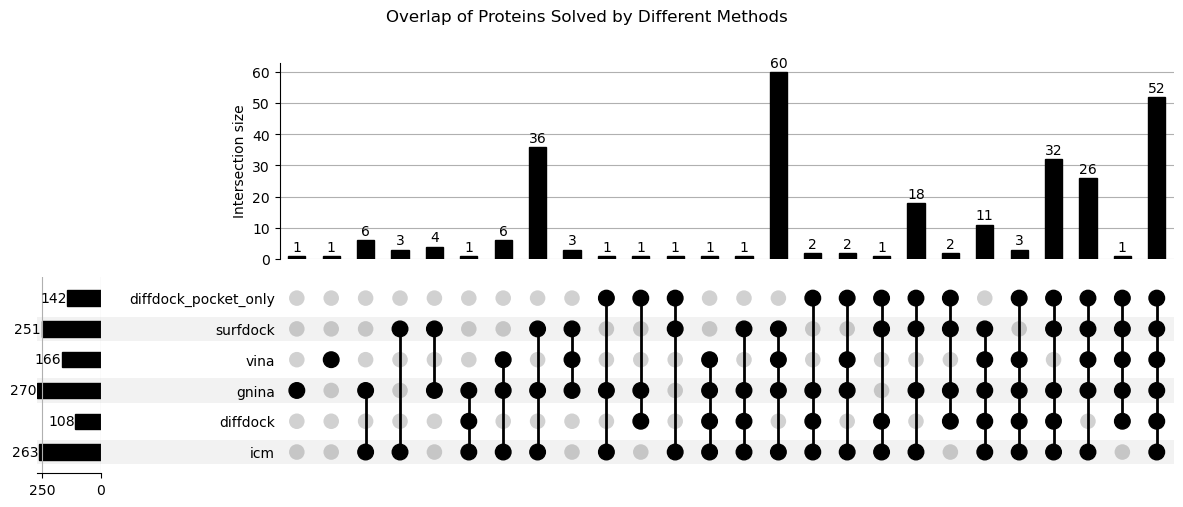

KeyError: 'protein'

In [36]:
from upsetplot import from_contents, UpSet

# 2) Make sets of proteins for each method
df_solved = success_counts.copy()
methods = ["icm", "diffdock", "gnina", "vina", "surfdock", "diffdock_pocket_only"]
method_sets = {}

for method in methods:
    mask = (success_counts[method])
    method_sets[method] = set( success_counts[mask].index.tolist())

# 3) Convert to an upsetplot-compatible structure
upset_data = from_contents(method_sets)

# 4) Create the UpSet figure
UpSet(upset_data, show_counts=True, subset_size='count', sort_categories_by=None).plot()
plt.suptitle("Overlap of Proteins Solved by Different Methods")
plt.show()

# Synergy example:
# Suppose you want to see proteins that exactly 'icm_solved' or 'diffdock_solved' but not the others:
# You can check the UpSet intersection or do a quick filter in the data:
df_solved["icm_or_diffdock"] = df_solved["icm"] | df_solved["diffdock"]
df_solved["others_solved"] = df_solved["gnina"] | df_solved["vina"] | df_solved["surfdock"]
synergy_df = df_solved[ (df_solved["icm_or_diffdock"]) & (~df_solved["others_solved"]) ]
print("Proteins solved by (ICM or DiffDock) but NOT by others:\n", synergy_df["protein"].tolist())

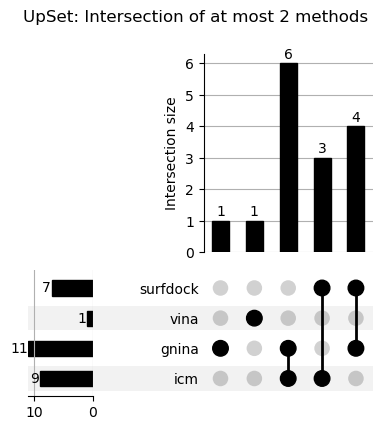

In [37]:
from upsetplot import from_indicators
# Example: we have booleans for 5 methods
# methods = ["icm", "diffdock", "gnina", "surfdock", "vina"]

# 1) For each row (protein), count how many methods = True
df_solved["num_methods"] = df_solved[methods].sum(axis=1)

# 2) Filter to keep only rows with up to 2 methods = True
df_filtered = df_solved[df_solved["num_methods"] <= 2].copy()

# 3) Build an UpSet-friendly structure. 
#    One easy way is from_indicators: for each method col, it must be boolean 
#    for "icm" or "diffdock", etc.
upset_data = from_indicators(methods, data=df_filtered[methods])

# 4) Create and plot the UpSet
UpSet(
    upset_data, 
    show_counts=True, 
    subset_size='count', 
    sort_categories_by=None
).plot()

plt.suptitle("UpSet: Intersection of at most 2 methods")
plt.show()

### In-depth analysis for failed cases for ICM

In [57]:
failed_proteins = success_counts[success_counts['icm'] == False].index.tolist()
print(f"Proteins where ICM failed: {failed_proteins}")

# Optional: See full details for these proteins
icm_failures = df_combined[
    (df_combined['protein'].isin(failed_proteins)) & 
    (df_combined['method'] == 'icm')
]
# display(icm_failures)

Proteins where ICM failed: ['6TW7_NZB', '6ZAE_ACV', '7PK0_BYC', '7PT3_3KK', '7QE4_NGA', '7R3D_APR', '7RNI_60I', '7U0U_FK5', '7WUX_6OI', '7XBV_APC', '8B8H_OJQ', '8D19_GSH', '8HFN_XGC']


In [58]:
# 1. Get ICM failed proteins
icm_failed = success_counts[success_counts['icm'] == False].index

# 2. Create comparison table for failed proteins
failure_comparison = success_counts.loc[icm_failed]

# 3. Display results
print("Success/Failure patterns for ICM-failed proteins:")
display(failure_comparison)

Success/Failure patterns for ICM-failed proteins:


method,chai-1,diffdock,diffdock_pocket_only,gnina,icm,surfdock,vina
protein,,,,,,,
6TW7_NZB,True,True,True,True,False,False,False
6ZAE_ACV,True,False,False,True,False,True,False
7PK0_BYC,True,False,False,False,False,False,True
7PT3_3KK,False,False,False,True,False,True,True
7QE4_NGA,True,True,True,True,False,True,False
7R3D_APR,True,False,False,True,False,True,True
7RNI_60I,False,False,False,True,False,True,False
7U0U_FK5,False,False,False,True,False,False,False
7WUX_6OI,False,False,False,True,False,True,True


### Rank-1 Statistics

In [73]:
for method in ["icm", "diffdock", "chai-1", "vina", "gnina"]:
    tmp = df_combined.loc[df_combined['method']== method]
    tmp = tmp.loc[tmp['rank'] == 1]
    print(tmp['success'].value_counts())

success
True     204
False     75
Name: count, dtype: int64
success
False    115
True      93
Name: count, dtype: int64
success
False    161
True     118
Name: count, dtype: int64
success
False    150
True     127
Name: count, dtype: int64
success
True     234
False     45
Name: count, dtype: int64


In [119]:
# Suppose we only compare rank=1 for each method
# (or min RMSD across top5)
# Then pivot:
pivot_df = df_combined[df_combined["rank"]==1].pivot(
    index="protein",
    columns="method",
    values="rmsd"
)

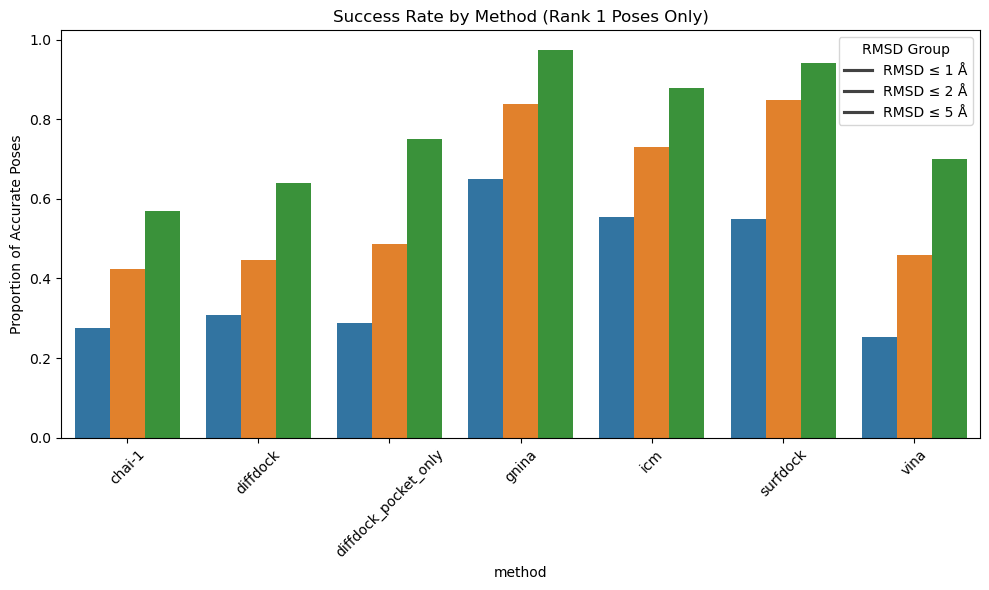

In [130]:
# Filter for rank 1 results
rank1_df = df_combined[df_combined['rank'] == 1]

# Calculate success rates for different thresholds
melted = rank1_df.melt(id_vars='method', 
                       value_vars=['rmsd_≤_1å', 'rmsd_≤_2å', 'rmsd_≤_5å'],
                       var_name='RMSD_Group',
                       value_name='Is_Accurate')

# Calculate proportion for each method and threshold
prop = melted.groupby(['method', 'RMSD_Group'])['Is_Accurate'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=prop, x='method', y='Is_Accurate', hue='RMSD_Group')
plt.ylabel('Proportion of Accurate Poses')
plt.title('Success Rate by Method (Rank 1 Poses Only)')
plt.legend(title='RMSD Group', labels=['RMSD ≤ 1 Å', 'RMSD ≤ 2 Å', 'RMSD ≤ 5 Å'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [120]:
pivot_df

method,chai-1,diffdock,diffdock_pocket_only,gnina,icm,surfdock,vina
protein,,,,,,,
5SAK_ZRY,1.214784,6.515625,4.285010,0.197836,0.791606,0.381460,0.342959
5SB2_1K2,0.380377,0.369257,0.484013,0.169000,0.301782,0.468485,10.349060
5SD5_HWI,1.424242,2.330589,2.007534,0.638371,0.760788,1.347217,4.249302
6M2B_EZO,1.484764,1.421802,1.444155,0.809554,0.261585,9.134642,1.699570
6M73_FNR,0.150232,0.377187,0.298150,0.499826,0.373483,0.639848,1.089174
...,...,...,...,...,...,...,...
8G0V_YHT,53.469311,NaN,0.566859,1.036807,0.600577,0.771463,1.719447
8GFD_ZHR,13.816361,13.588672,15.209019,3.159062,1.464670,1.092103,7.091421
8HFN_XGC,1.107139,2.066554,2.037451,0.482904,10.598874,0.577637,3.081582


In [59]:
df_combined['rmsd'] = np.log1p(df_combined['rmsd'])

### plot_rmsd_comparisons

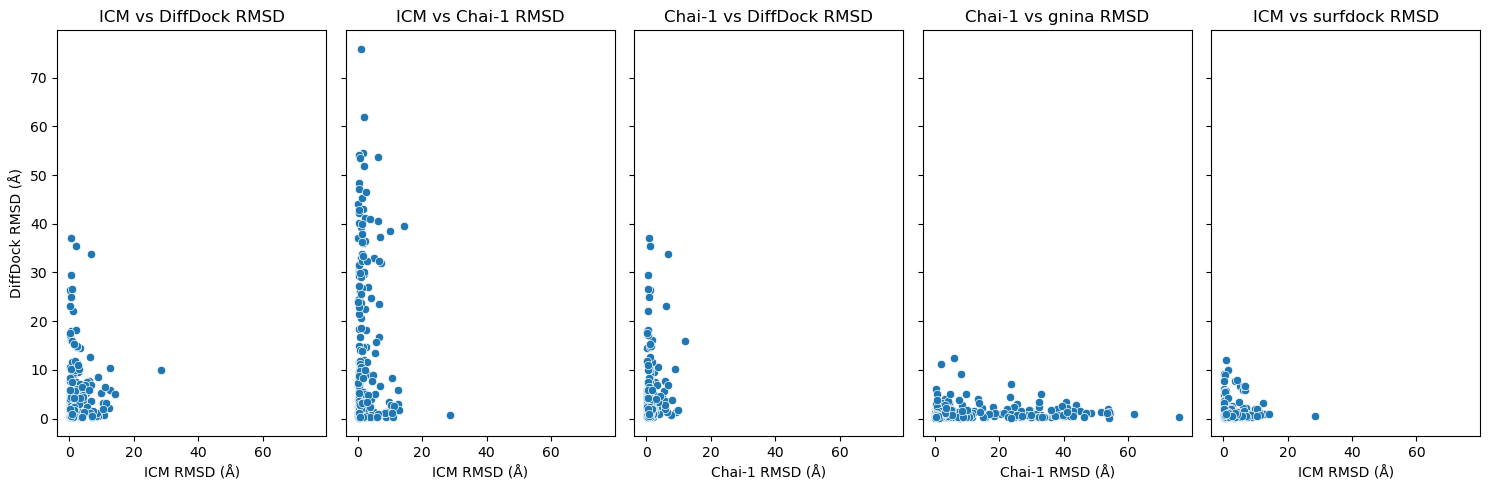

In [129]:
# Create subplots for all three comparisons
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)

# ICM vs DiffDock
sns.scatterplot(data=pivot_df, x='icm', y='diffdock_pocket_only', ax=ax1)
ax1.set_xlabel('ICM RMSD (Å)')
ax1.set_ylabel('DiffDock RMSD (Å)')
ax1.set_title('ICM vs DiffDock RMSD')

# ICM vs Chai-1
sns.scatterplot(data=pivot_df, x='icm', y='chai-1', ax=ax2)
ax2.set_xlabel('ICM RMSD (Å)')
ax2.set_ylabel('Chai-1 RMSD (Å)')
ax2.set_title('ICM vs Chai-1 RMSD')

# Chai-1 vs DiffDock
sns.scatterplot(data=pivot_df, x='surfdock', y='diffdock_pocket_only', ax=ax3)
ax3.set_xlabel('Chai-1 RMSD (Å)')
ax3.set_ylabel('DiffDock RMSD (Å)')
ax3.set_title('Chai-1 vs DiffDock RMSD')

# Diffdock vs gnina
sns.scatterplot(data=pivot_df, x='chai-1', y='gnina', ax=ax4)
ax4.set_xlabel('Chai-1 RMSD (Å)')
ax4.set_ylabel('gnina RMSD (Å)')
ax4.set_title('Chai-1 vs gnina RMSD')

# chai-1 vs surfdock
sns.scatterplot(data=pivot_df, x='icm', y='surfdock', ax=ax5)
ax5.set_xlabel('ICM RMSD (Å)')
ax5.set_ylabel('surfdock RMSD (Å)')
ax5.set_title('ICM vs surfdock RMSD')

plt.tight_layout()
plt.show()

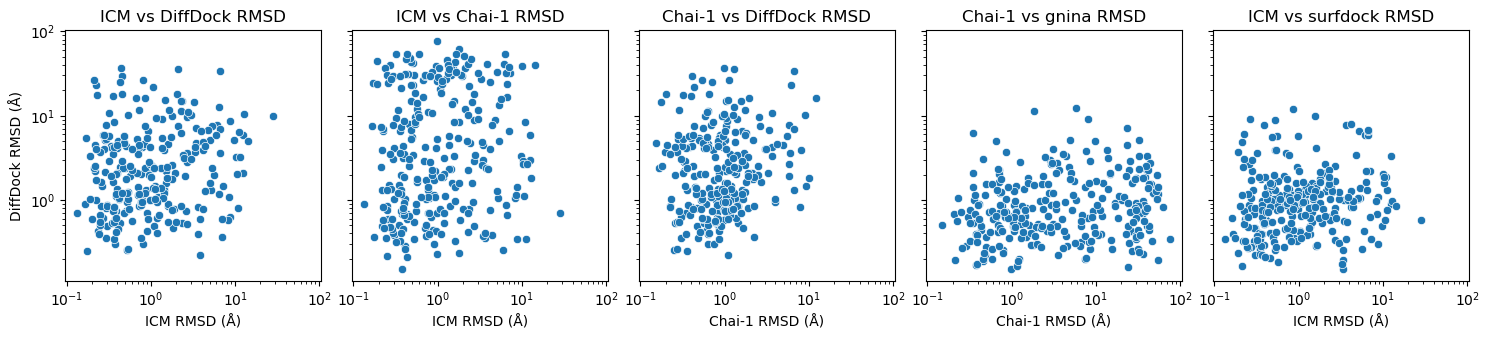

In [128]:
# Create subplots for all three comparisons
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)

# ICM vs DiffDock
sns.scatterplot(data=pivot_df, x='icm', y='diffdock_pocket_only', ax=ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('ICM RMSD (Å)')
ax1.set_ylabel('DiffDock RMSD (Å)')
ax1.set_title('ICM vs DiffDock RMSD')

# ICM vs Chai-1
sns.scatterplot(data=pivot_df, x='icm', y='chai-1', ax=ax2)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('ICM RMSD (Å)')
ax2.set_ylabel('Chai-1 RMSD (Å)')
ax2.set_title('ICM vs Chai-1 RMSD')

# Chai-1 vs DiffDock
sns.scatterplot(data=pivot_df, x='surfdock', y='diffdock_pocket_only', ax=ax3)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Chai-1 RMSD (Å)')
ax3.set_ylabel('Diffdock_pocket_only RMSD (Å)')
ax3.set_title('Chai-1 vs DiffDock RMSD')

# Diffdock vs gnina
sns.scatterplot(data=pivot_df, x='chai-1', y='gnina', ax=ax4)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('Chai-1 RMSD (Å)')
ax4.set_ylabel('gnina RMSD (Å)')
ax4.set_title('Chai-1 vs gnina RMSD')

# chai-1 vs surfdock
sns.scatterplot(data=pivot_df, x='icm', y='surfdock', ax=ax5)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel('ICM RMSD (Å)')
ax5.set_ylabel('surfdock RMSD (Å)')
ax5.set_title('ICM vs surfdock RMSD')

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set_aspect('equal', 'box')  # or 'datalim', see below
    
plt.tight_layout()
plt.show()


In [76]:
fig = px.scatter(
    pivot_df,
    x="icm",
    y="diffdock_pocket_only",
    hover_name=pivot_df.index
)
fig.update_traces(marker=dict(size=12, opacity=0.8))

# Make both axes use the same scale:
fig.update_yaxes(scaleanchor="x", scaleratio=1)

fig.show()

In [72]:
fig = px.scatter(
    pivot_df,
    x="surfdock",
    y="diffdock_pocket_only",
    hover_name=pivot_df.index
)
fig.show()

In [73]:
fig = px.scatter(
    pivot_df,
    x="icm",
    y="surfdock",
    hover_name=pivot_df.index
)
fig.show()

## 6. Model-Fitting or Statistical Analysis

In [ ]:
import statsmodels.formula.api as smf

df_subset = df_all.dropna(subset=["rmsd", "num_rotatable_bonds"])
model = smf.ols("rmsd ~ num_rotatable_bonds + C(method)", data=df_subset).fit()
print(model.summary())